In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso



# Change n_clusters to 5, 10 or 20

In [2]:
n_clusters = 20  #5, 10 or 20

In [3]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    #get_train_test_split,
    #get_trained_model,
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [4]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [5]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

# Delete Image Null

In [6]:
print(merged_df.shape)

merged_df = merged_df.dropna(subset=['pca_result'])

print(merged_df.shape)

(481, 78)
(473, 78)


In [7]:

feature_selection = f"{n_clusters}_clusters" 

features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    "total_precipitation_2023",
    #"longitude_sin", 
    #"longitude_cos", 
    #"latitude_sin", 
    #"latitude_cos",  
    "population_density",

    #Image data
    'pca_result'
    ]

features += [f'Cluster_{n_clusters}_{i}' for i in range(n_clusters)]


feature_abbreviations = {
    "hdd_total_year": "Heating Degree Days",
    "cdd_total_year": "Cooling Degree Days", 
    "GDP_per_capita": "GDP per Capita",
    "Urbanization_Rate_2022": "Urbanization Rate",
    "latitude": "Latitude",
    "longitude": "Longitude",  
    "Paris_Agreement": "Paris Agreement",
    "Subnational HDI": "Human Development Index",
    "Educational index": "Educational Index", 
    "Income index": "Income Index",
    "2m_temperature_2023_avg": "Avg Temperature",
    "2m_dewpoint_temperature_2023_avg": "Avg Dewpoint Temp",
    "total_precipitation_2023": "Precipitation",
    "longitude_sin": "Longitude Sin", 
    "longitude_cos": "Longitude Cos", 
    "latitude_sin": "Latitude Sin", 
    "latitude_cos": "Latitude Cos",  
    "population_density": "Population Density",

    # Image-based features
    "pca_result": "First Principal Component (PCA)",
}

feature_abbreviations.update({f'Cluster_{n_clusters}_{i}': f'Fuzzy C-means Image Cluster {i}' for i in range(n_clusters)})


target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# Linear Regression 

### Linear Regression - Within Domain

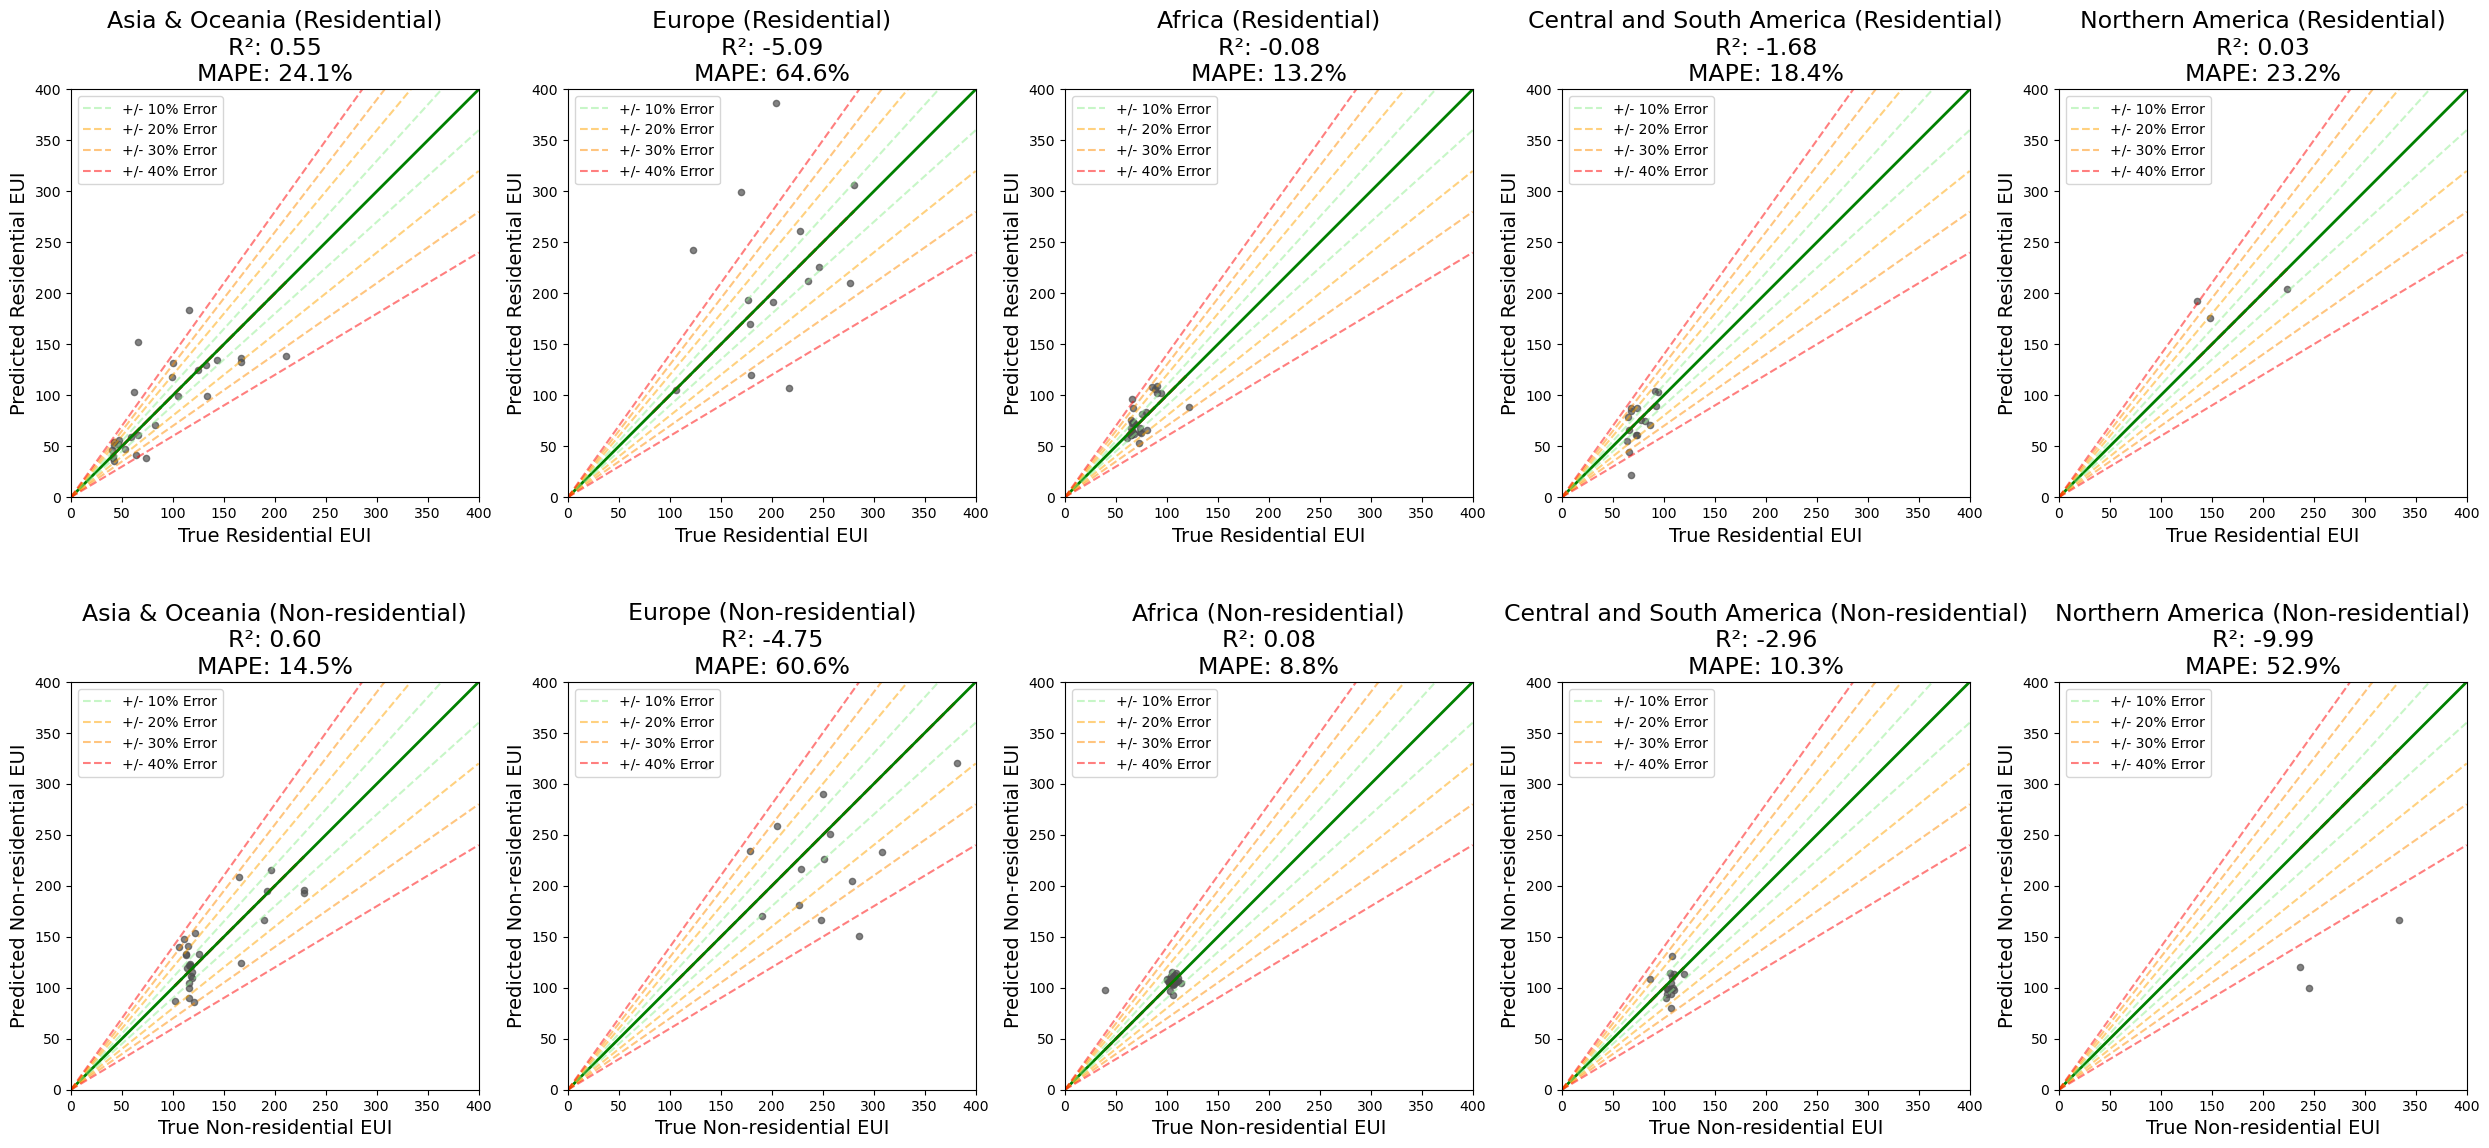

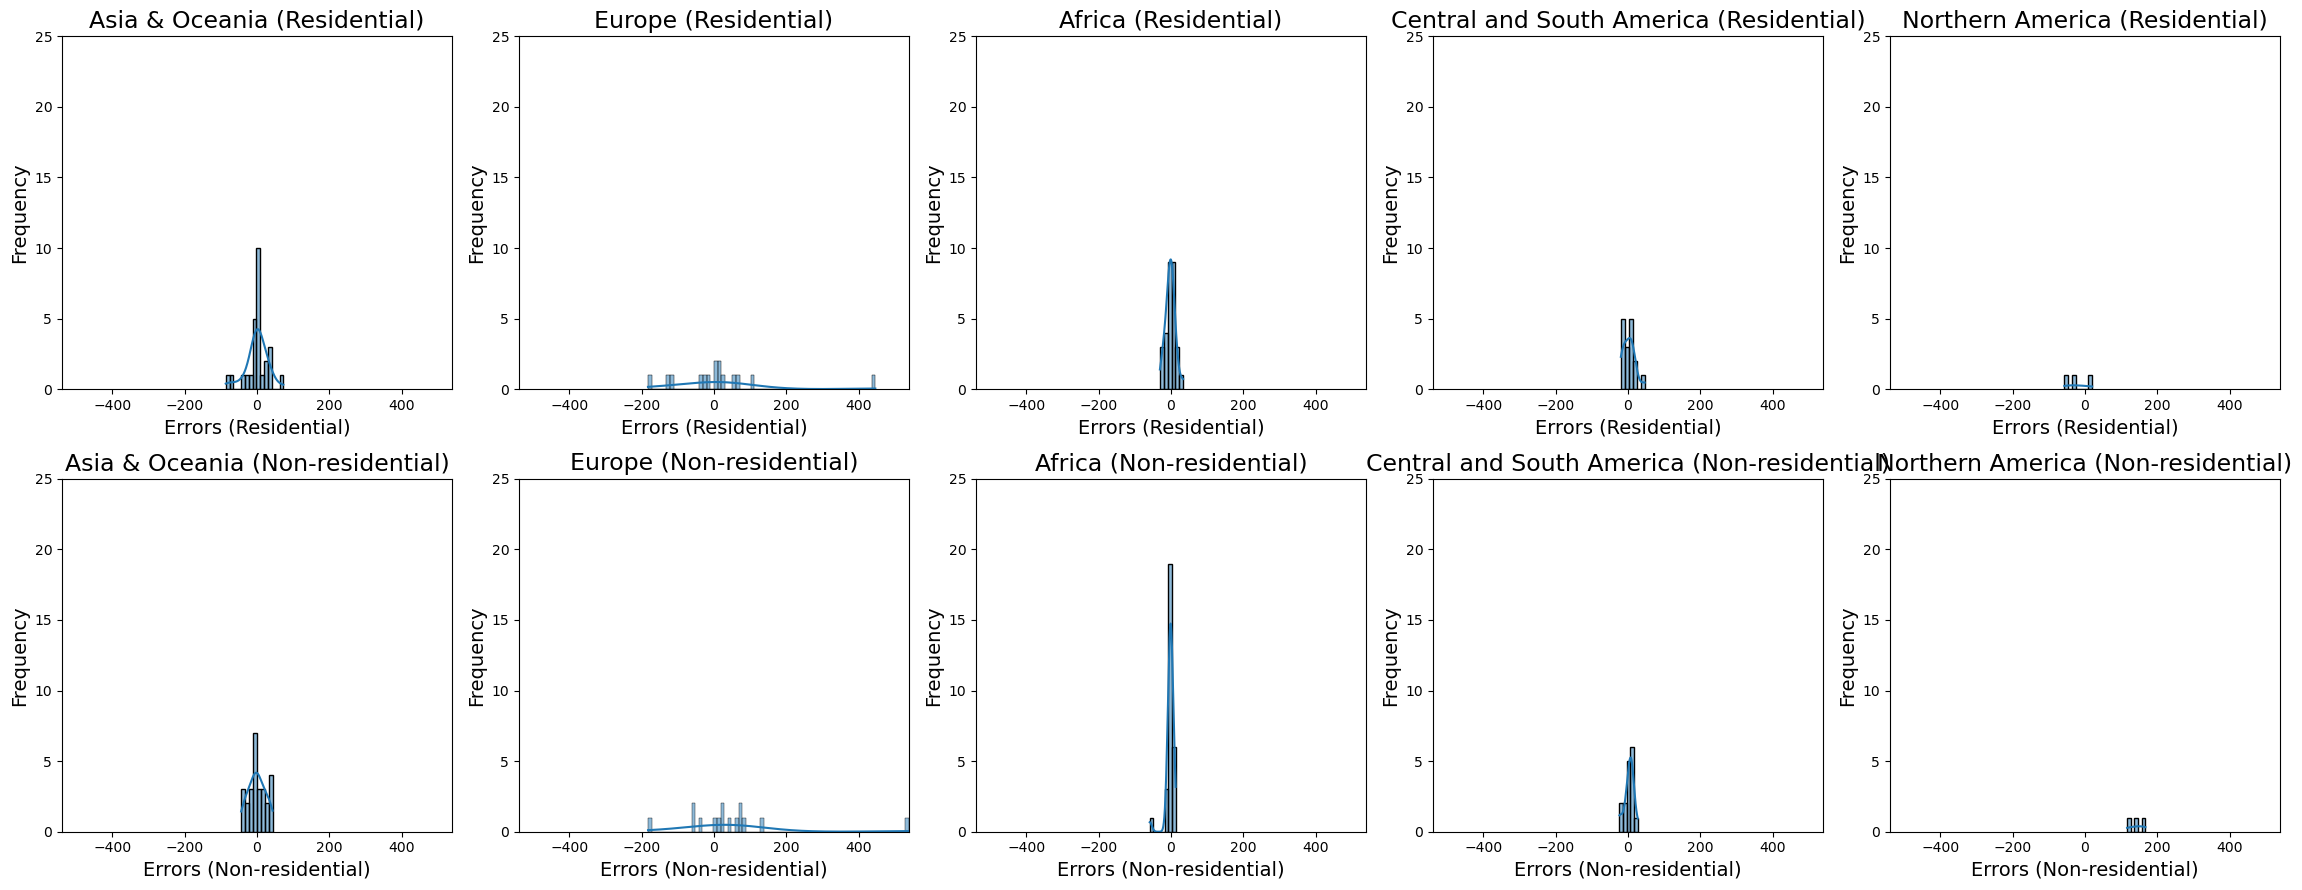

In [8]:
# Within-domain
model_lr_within = LinearRegression()
results_lr_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions, 
    features=features,
    model=model_lr_within,
    strategy='within_domain'
)

create_eui_comparison_plots(
    results_lr_within, 
    save_path=f'../figures/model_plots/{feature_selection}/lr_within_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_lr_within,
    save_path=f'../figures/model_plots/{feature_selection}/lr_within_domain_error_distribution.png'
)

### Linear Regression - Cross Domain

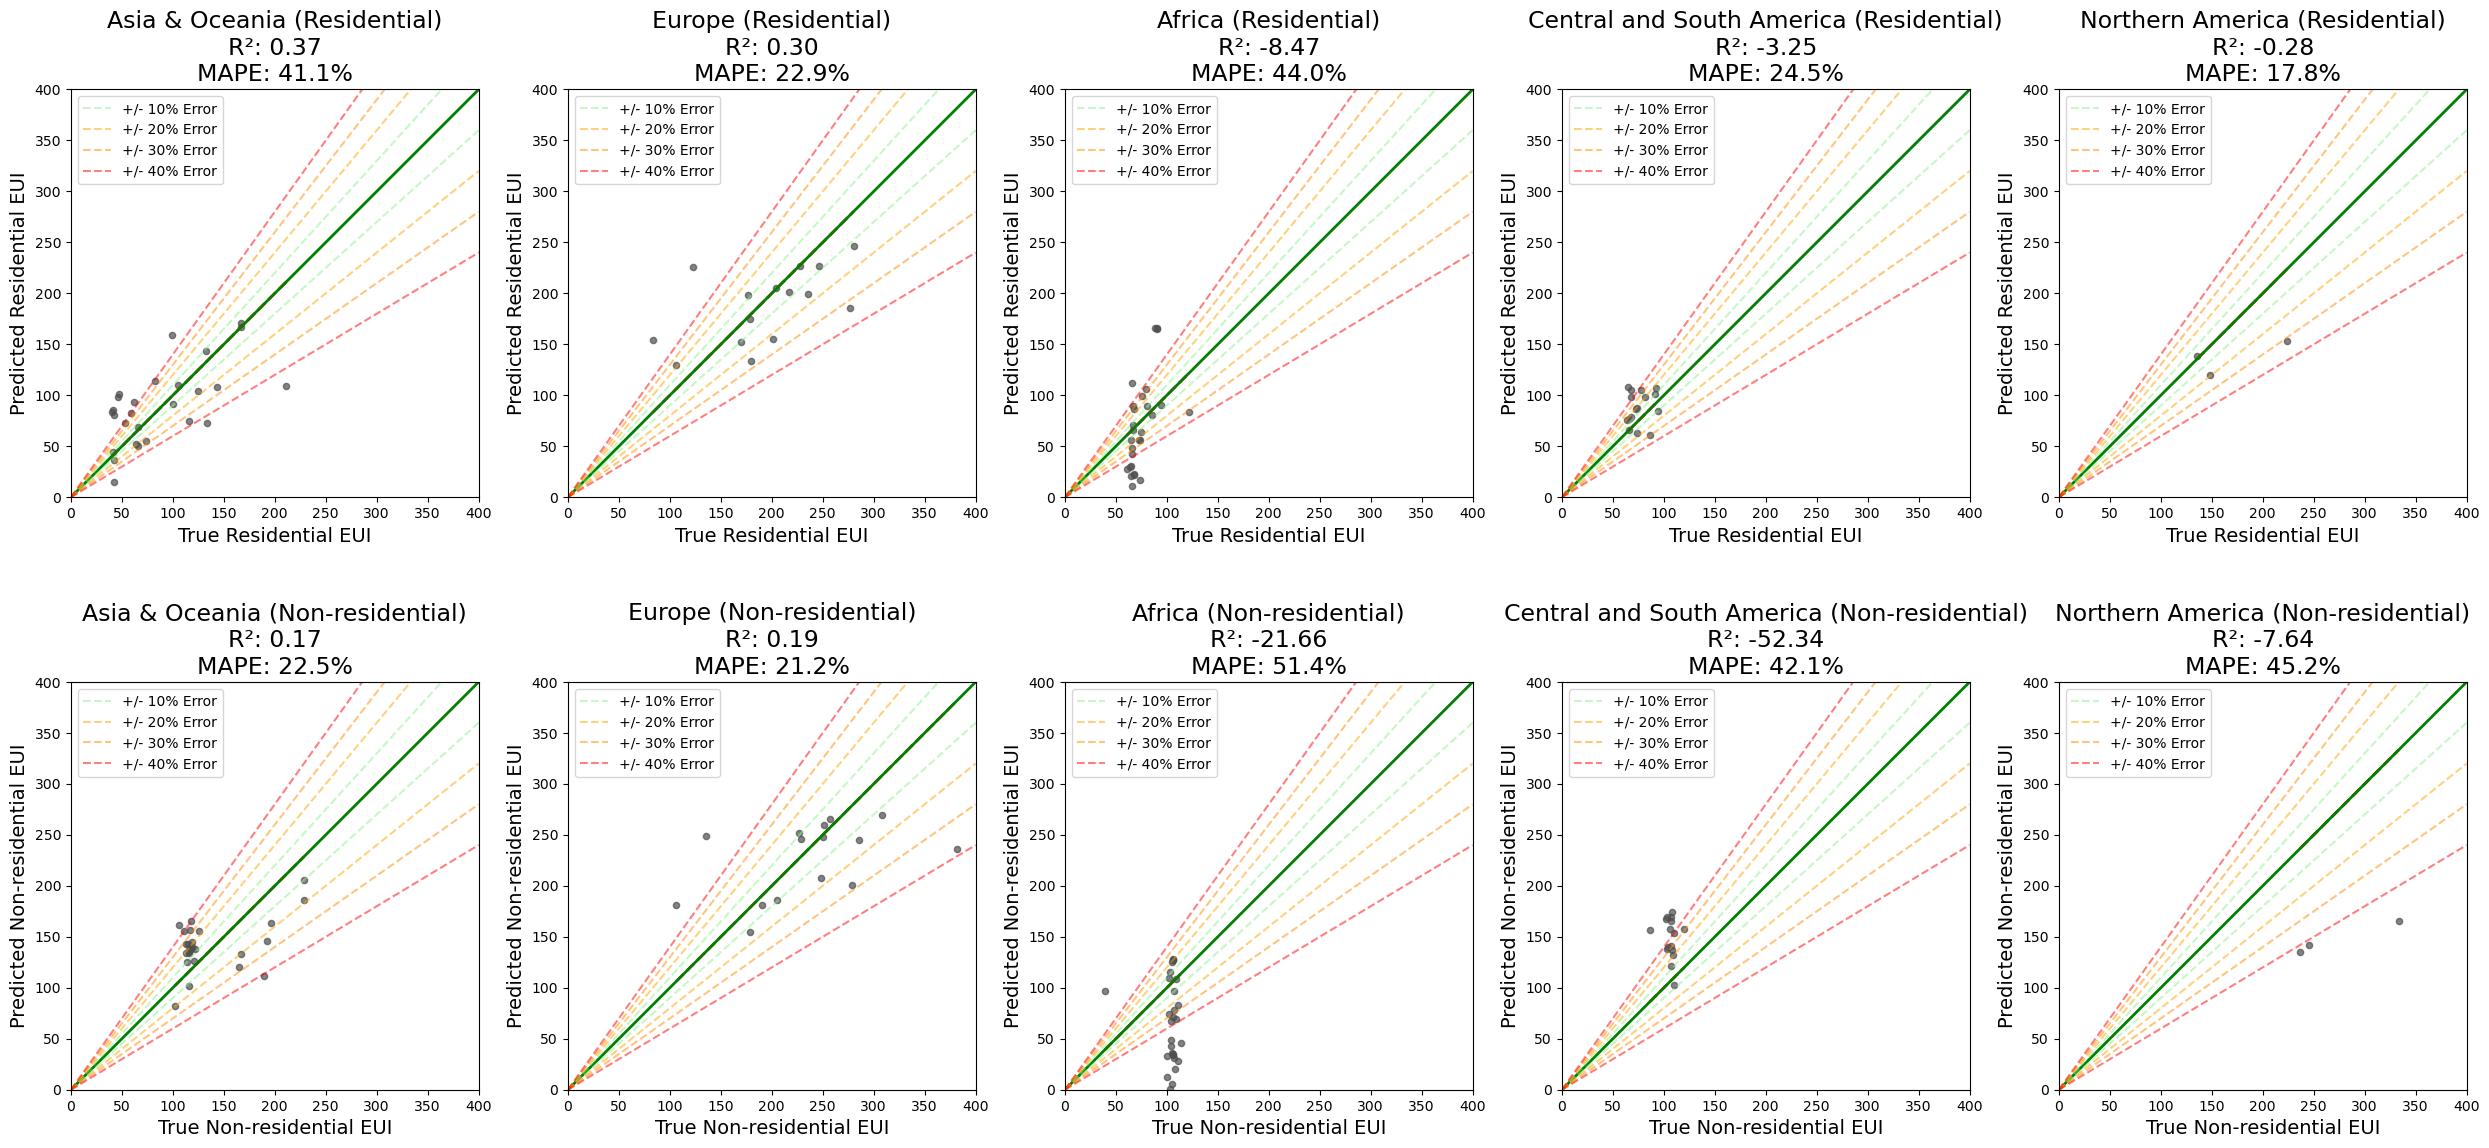

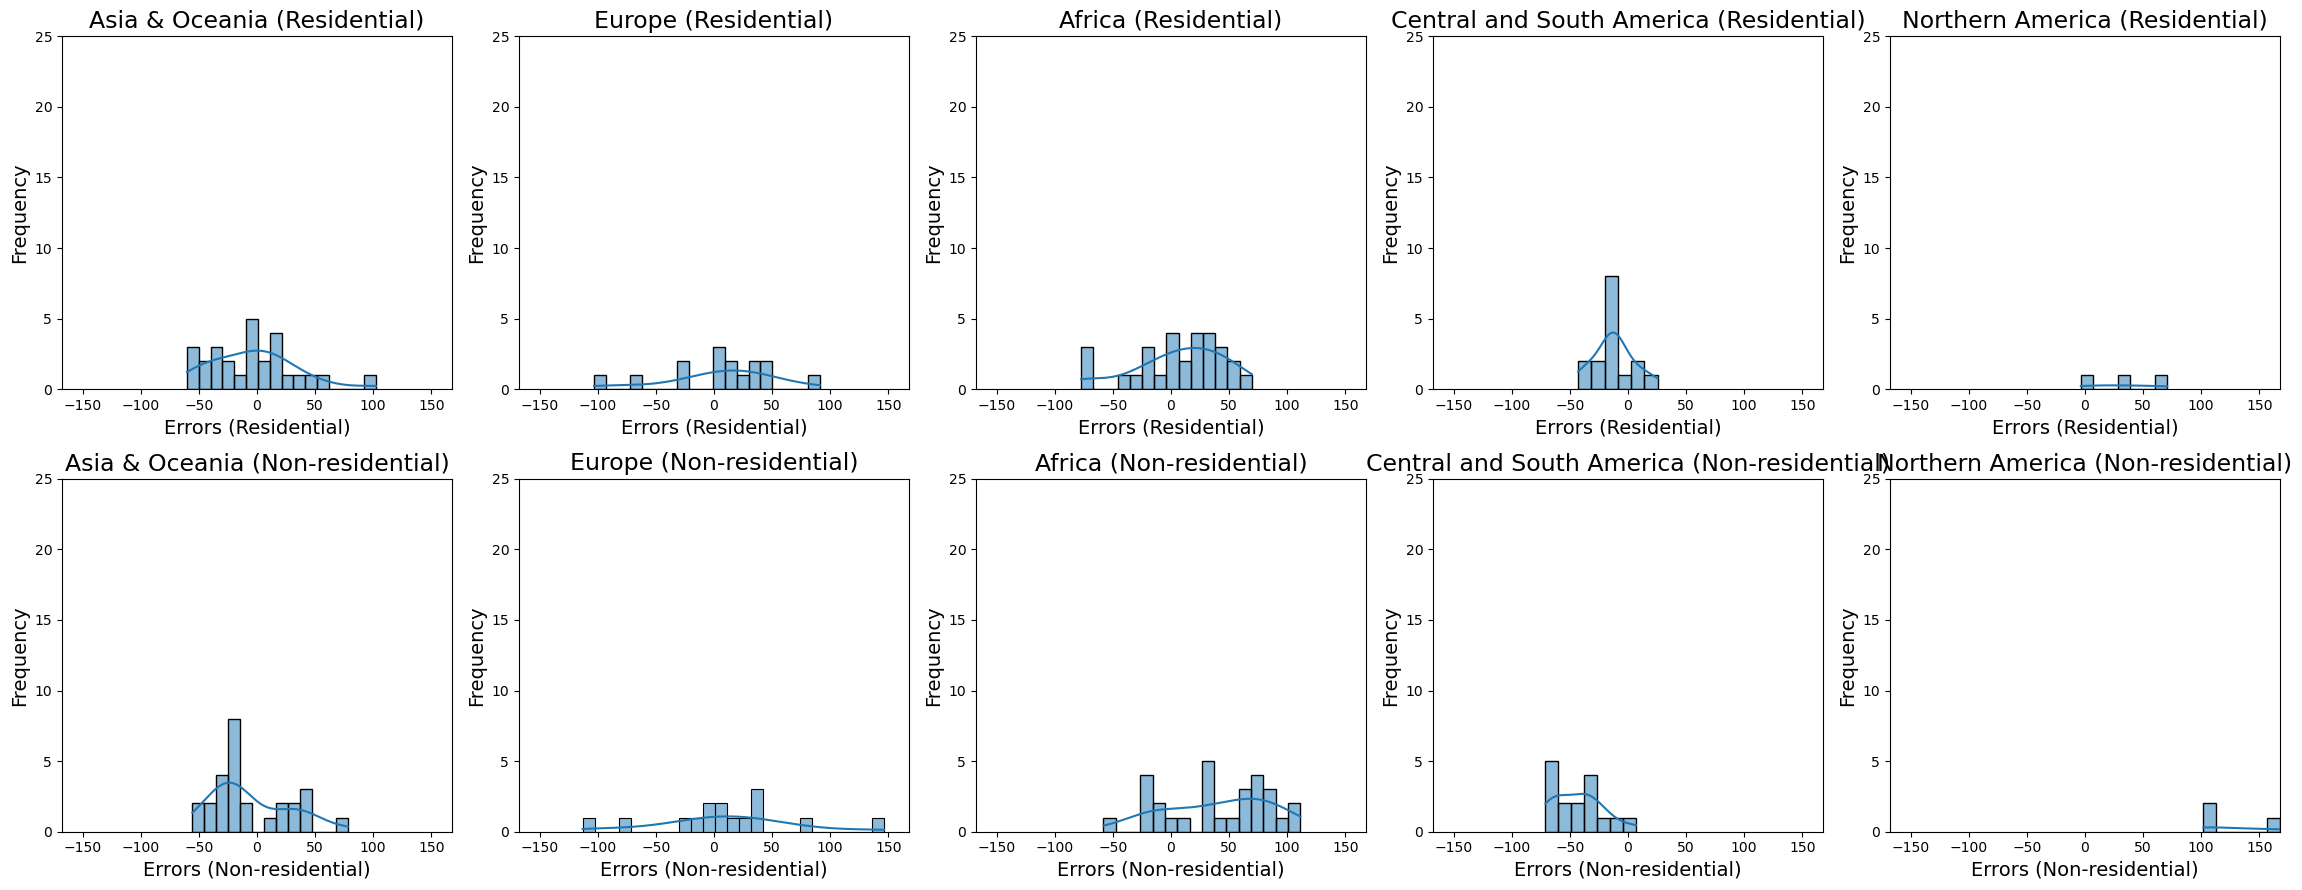

In [9]:
# Cross-domain 
model_lr_cross = LinearRegression()
results_lr_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features, 
    model=model_lr_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(
    results_lr_cross,
    save_path=f'../figures/model_plots/{feature_selection}/lr_cross_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_lr_cross,
    save_path=f'../figures/model_plots/{feature_selection}/lr_cross_domain_error_distribution.png'
)


### Linear Regression - All Domain

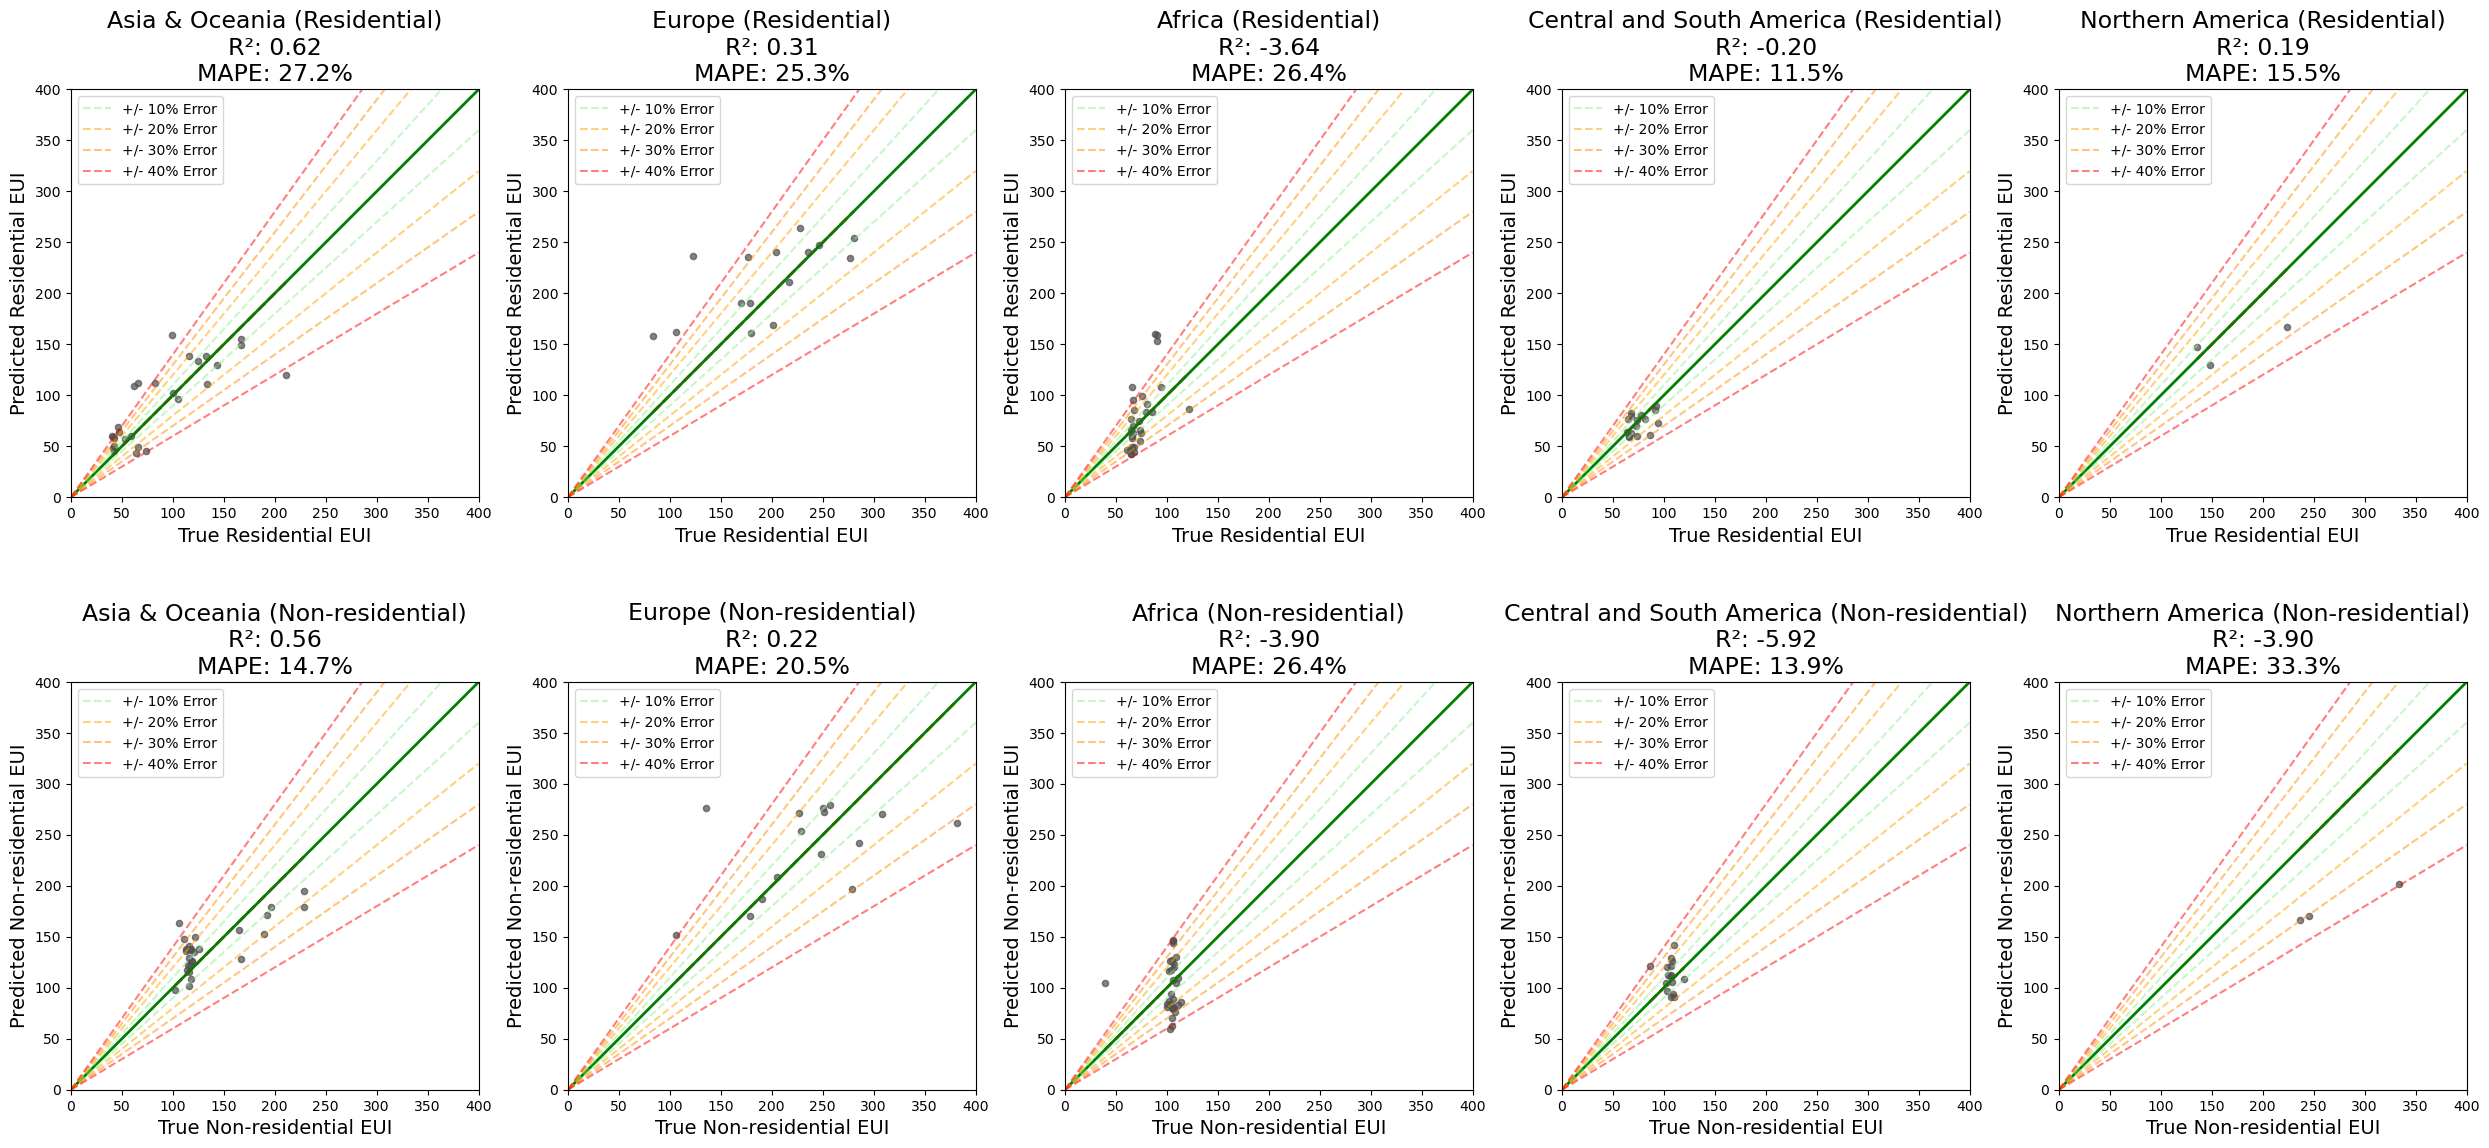

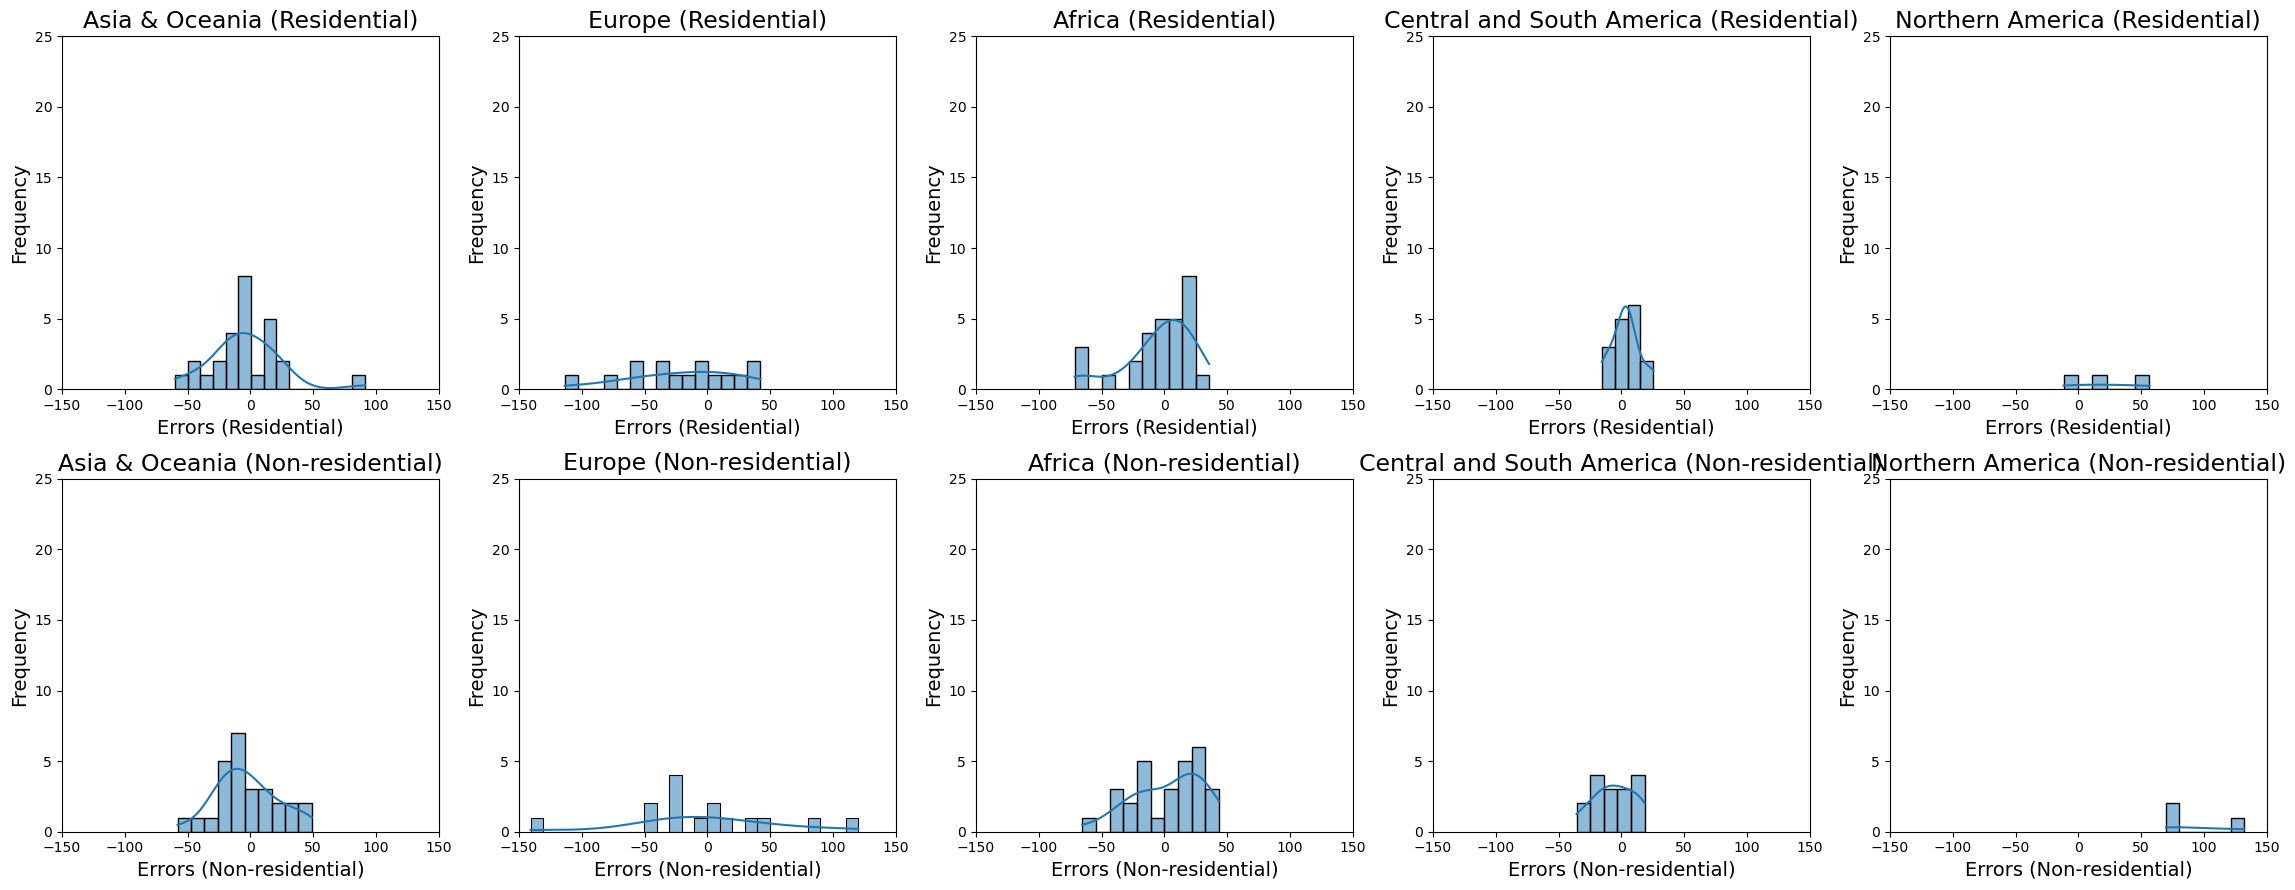

In [10]:
# All-domain
model_lr_all = LinearRegression()
results_lr_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_lr_all, 
    strategy='all_domain'
)

create_eui_comparison_plots(
    results_lr_all,
    save_path=f'../figures/model_plots/{feature_selection}/lr_all_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_lr_all,
    save_path=f'../figures/model_plots/{feature_selection}/lr_all_domain_error_distribution.png'
)


In [11]:
lr_detailed_results = evaluate_model_strategies(
   merged_df=merged_df,
   regions=regions,
   features=features,
   model_type=LinearRegression,
   feature_abbreviations=feature_abbreviations,
   model_details="No regularization"
)

lr_average_results = calculate_average_metrics(lr_detailed_results).reset_index()
lr_average_results

Target       Strategy             Model  \
0  Non-residential EUI (kWh/m2/year)  within_domain  LinearRegression   
1  Non-residential EUI (kWh/m2/year)   cross_domain  LinearRegression   
2  Non-residential EUI (kWh/m2/year)     all_domain  LinearRegression   
3      Residential EUI (kWh/m2/year)  within_domain  LinearRegression   
4      Residential EUI (kWh/m2/year)   cross_domain  LinearRegression   
5      Residential EUI (kWh/m2/year)     all_domain  LinearRegression   

       Model Details                                      Features Used  \
0  No regularization  hdd_total_year, cdd_total_year, GDP_per_capita...   
1  No regularization  hdd_total_year, cdd_total_year, GDP_per_capita...   
2  No regularization  hdd_total_year, cdd_total_year, GDP_per_capita...   
3  No regularization  hdd_total_year, cdd_total_year, GDP_per_capita...   
4  No regularization  hdd_total_year, cdd_total_year, GDP_per_capita...   
5  No regularization  hdd_total_year, cdd_total_year, GDP_per_capita...   

                                Features Abbreviated   MAPE      R²       MSE  \
0  Heating Degree Days | Cooling Degree Days | GD...  29.42  -3.402  9343.113   
1  Heating Degree Days | Cooling Degree Days | GD...  36.48 -16.256  5393.639   
2  Heating Degree Days | Cooling Degree Days | GD...  21.76  -2.588  2880.414   
3  Heating Degree Days | Cooling Degree Days | GD...  28.70  -1.252  4398.655   
4  Heating Degree Days | Cooling Degree Days | GD...  30.06  -2.265  1499.143   
5  Heating Degree Days | Cooling Degree Days | GD...  21.18  -0.543  1022.067   

     RMSE     MAE   WAPE  
0  70.218  54.582  24.50  
1  65.820  58.522  35.34  
2  44.912  38.754  20.76  
3  47.550  32.553  23.80  
4  37.672  29.736  27.72  
5  29.853  23.059  19.74

In [12]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
lr_detailed_results.to_csv(f'../results/{feature_selection}/{timestamp}_lr_detailed_results.csv')
lr_average_results.to_csv(f'../results/{feature_selection}/{timestamp}_lr_average_results.csv')

# 

# Linear Regression - Ridge regularization

In [13]:
ridge_params = {
    'alpha': 1.0,          # regularization strength
   # 'fit_intercept': True, # include bias term
   # 'max_iter': 1000,      # maximum iterations
   # 'tol': 1e-3,          # tolerance for optimization
   # 'solver': 'auto',      # solver algorithm
   # 'random_state': 42     # for reproducibility
}

### Linear Regression - Ridge - Within Domain

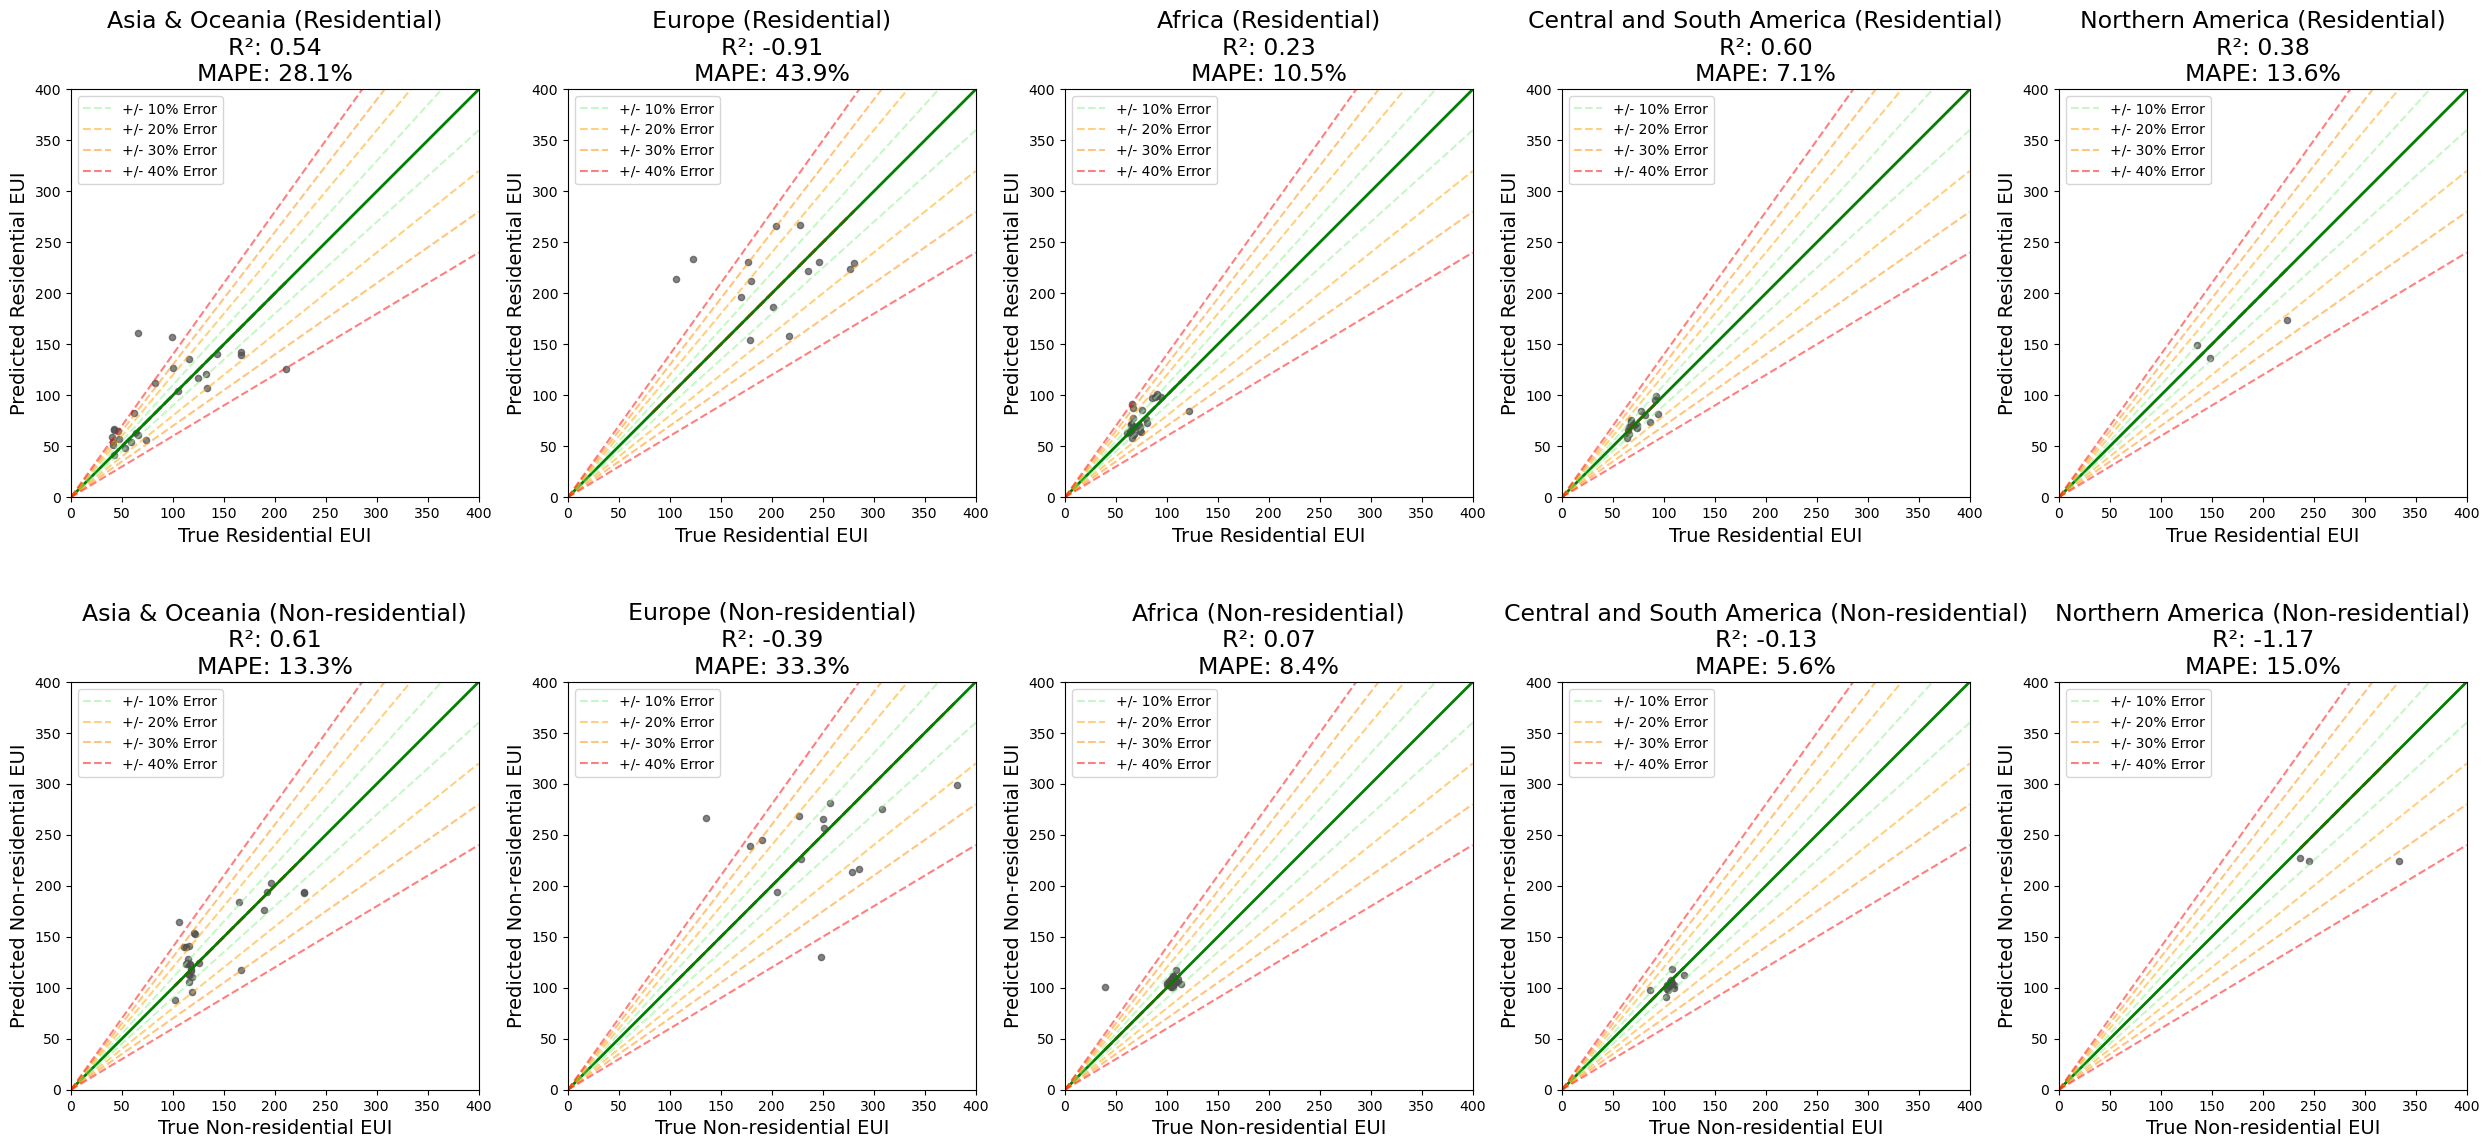

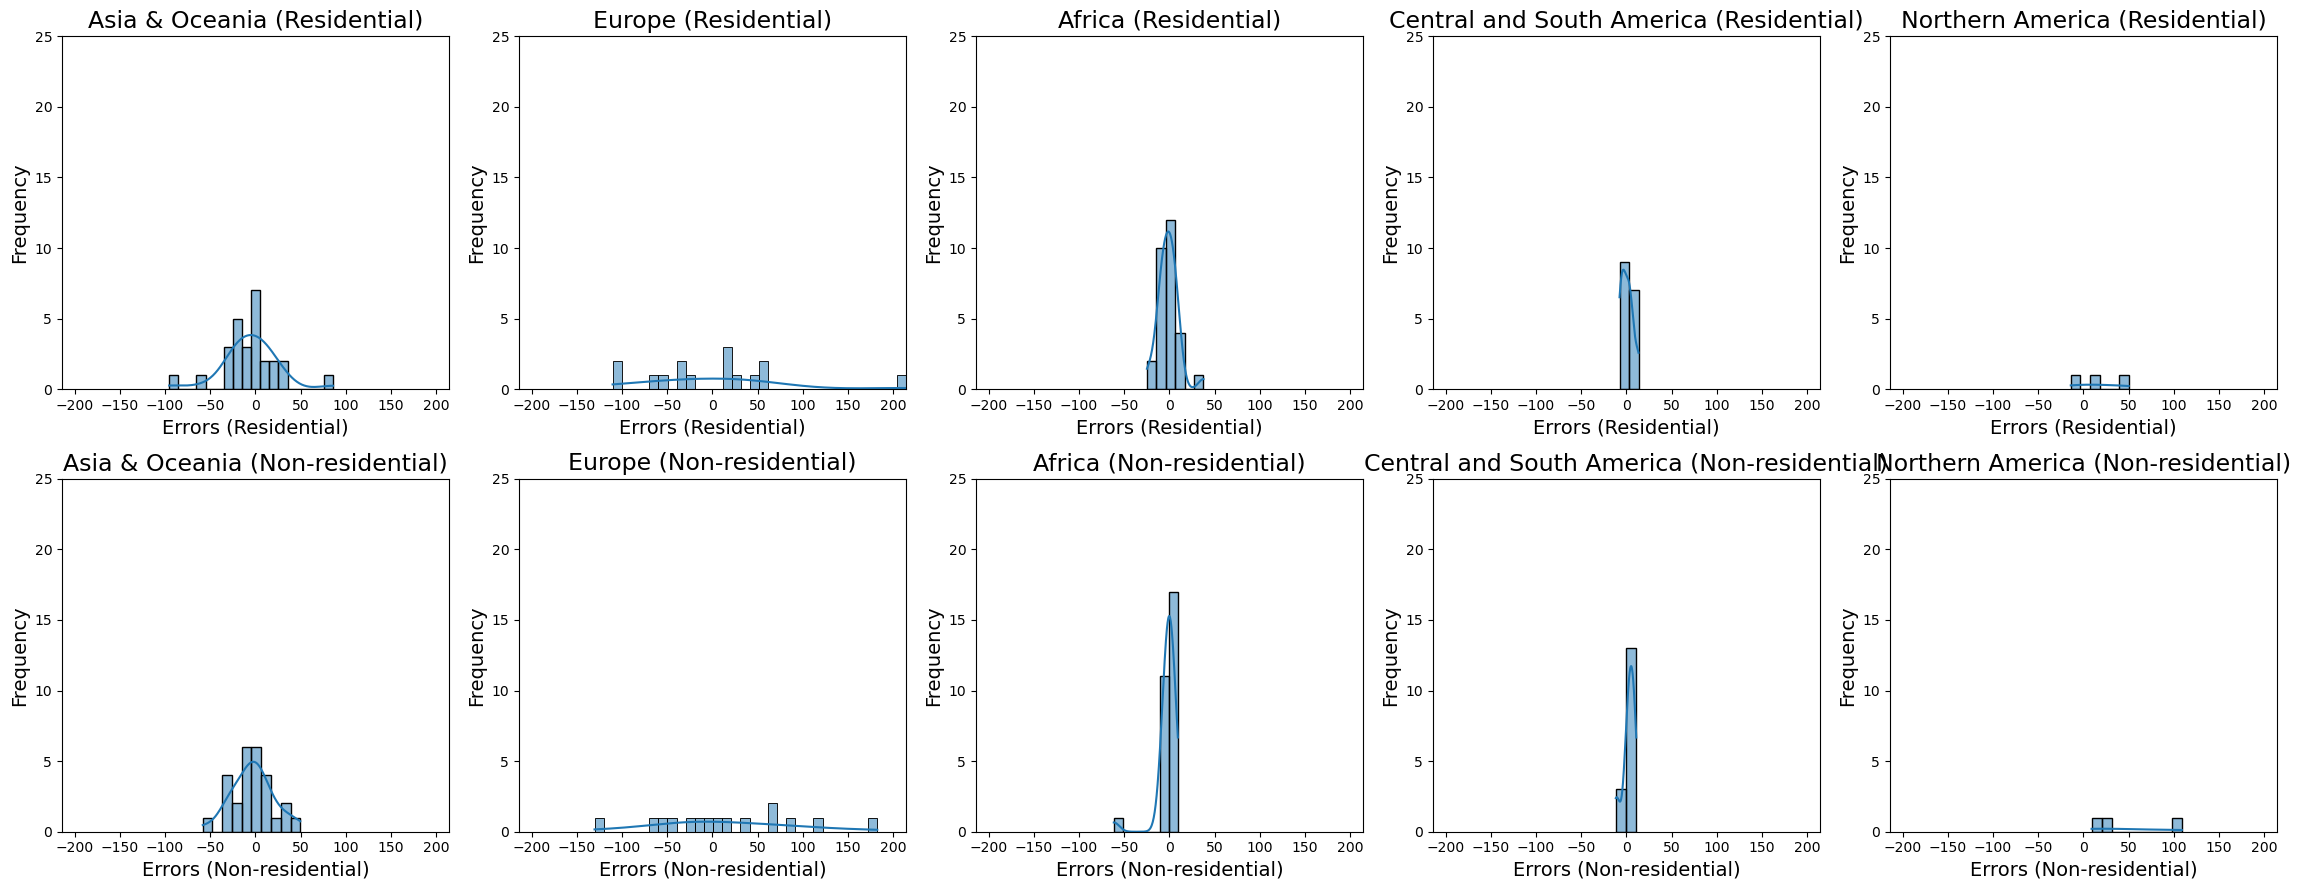

In [14]:
# Within-domain with Ridge
model_ridge_within = Ridge(**ridge_params)
results_ridge_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions, 
    features=features,
    model=model_ridge_within,
    strategy='within_domain'
)

create_eui_comparison_plots(
    results_ridge_within, 
    save_path=f'../figures/model_plots/{feature_selection}/ridge_within_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_ridge_within,
    save_path=f'../figures/model_plots/{feature_selection}/ridge_within_domain_error_distribution.png'
)

### Linear Regression - Ridge - Cross Domain

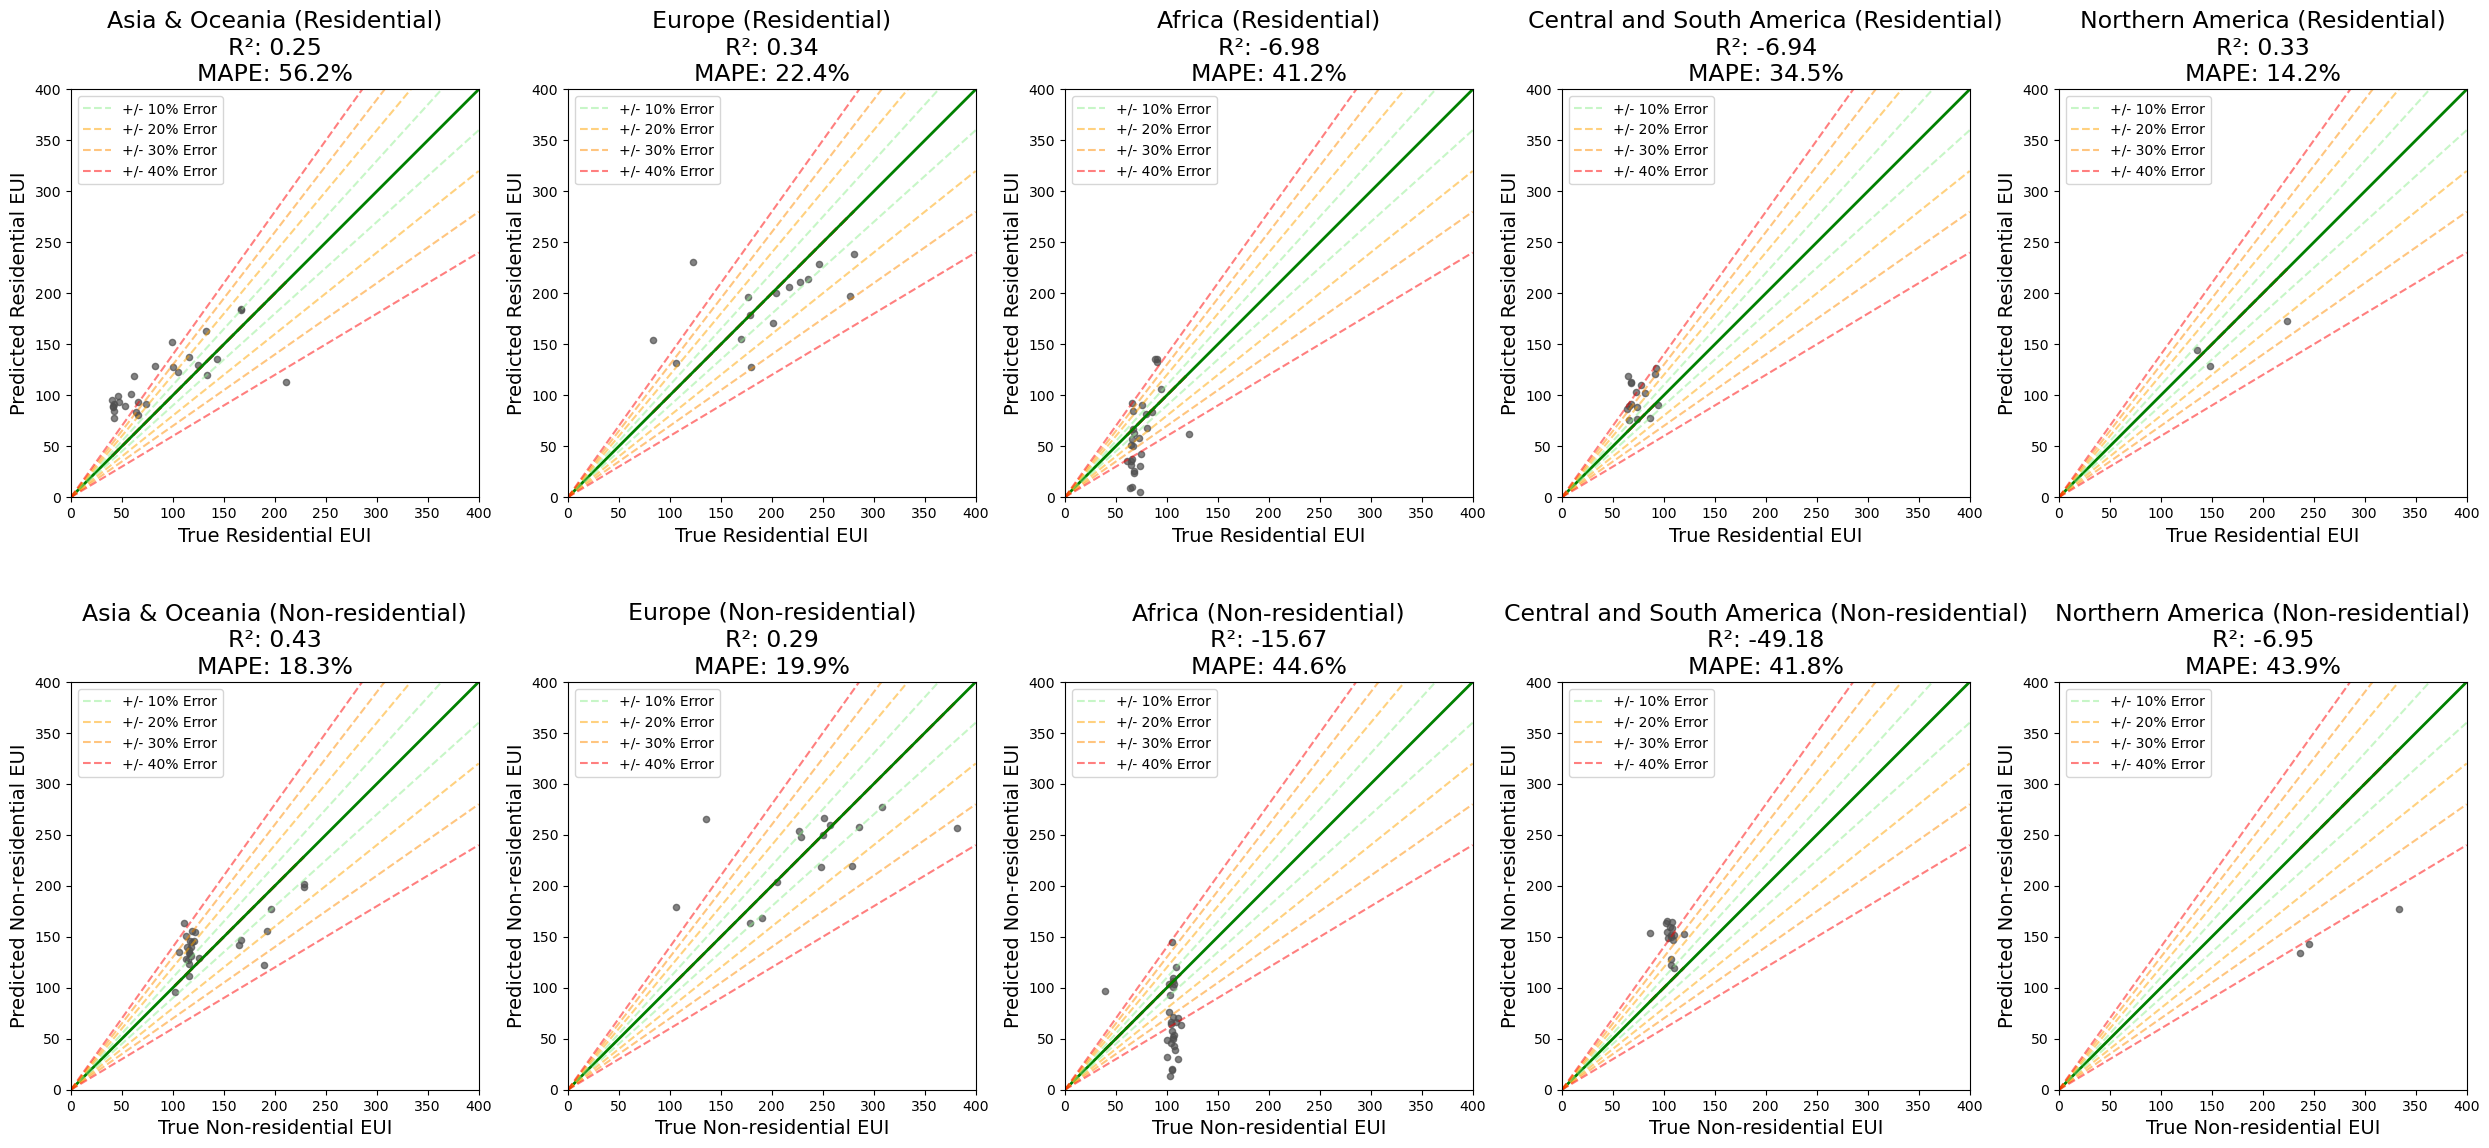

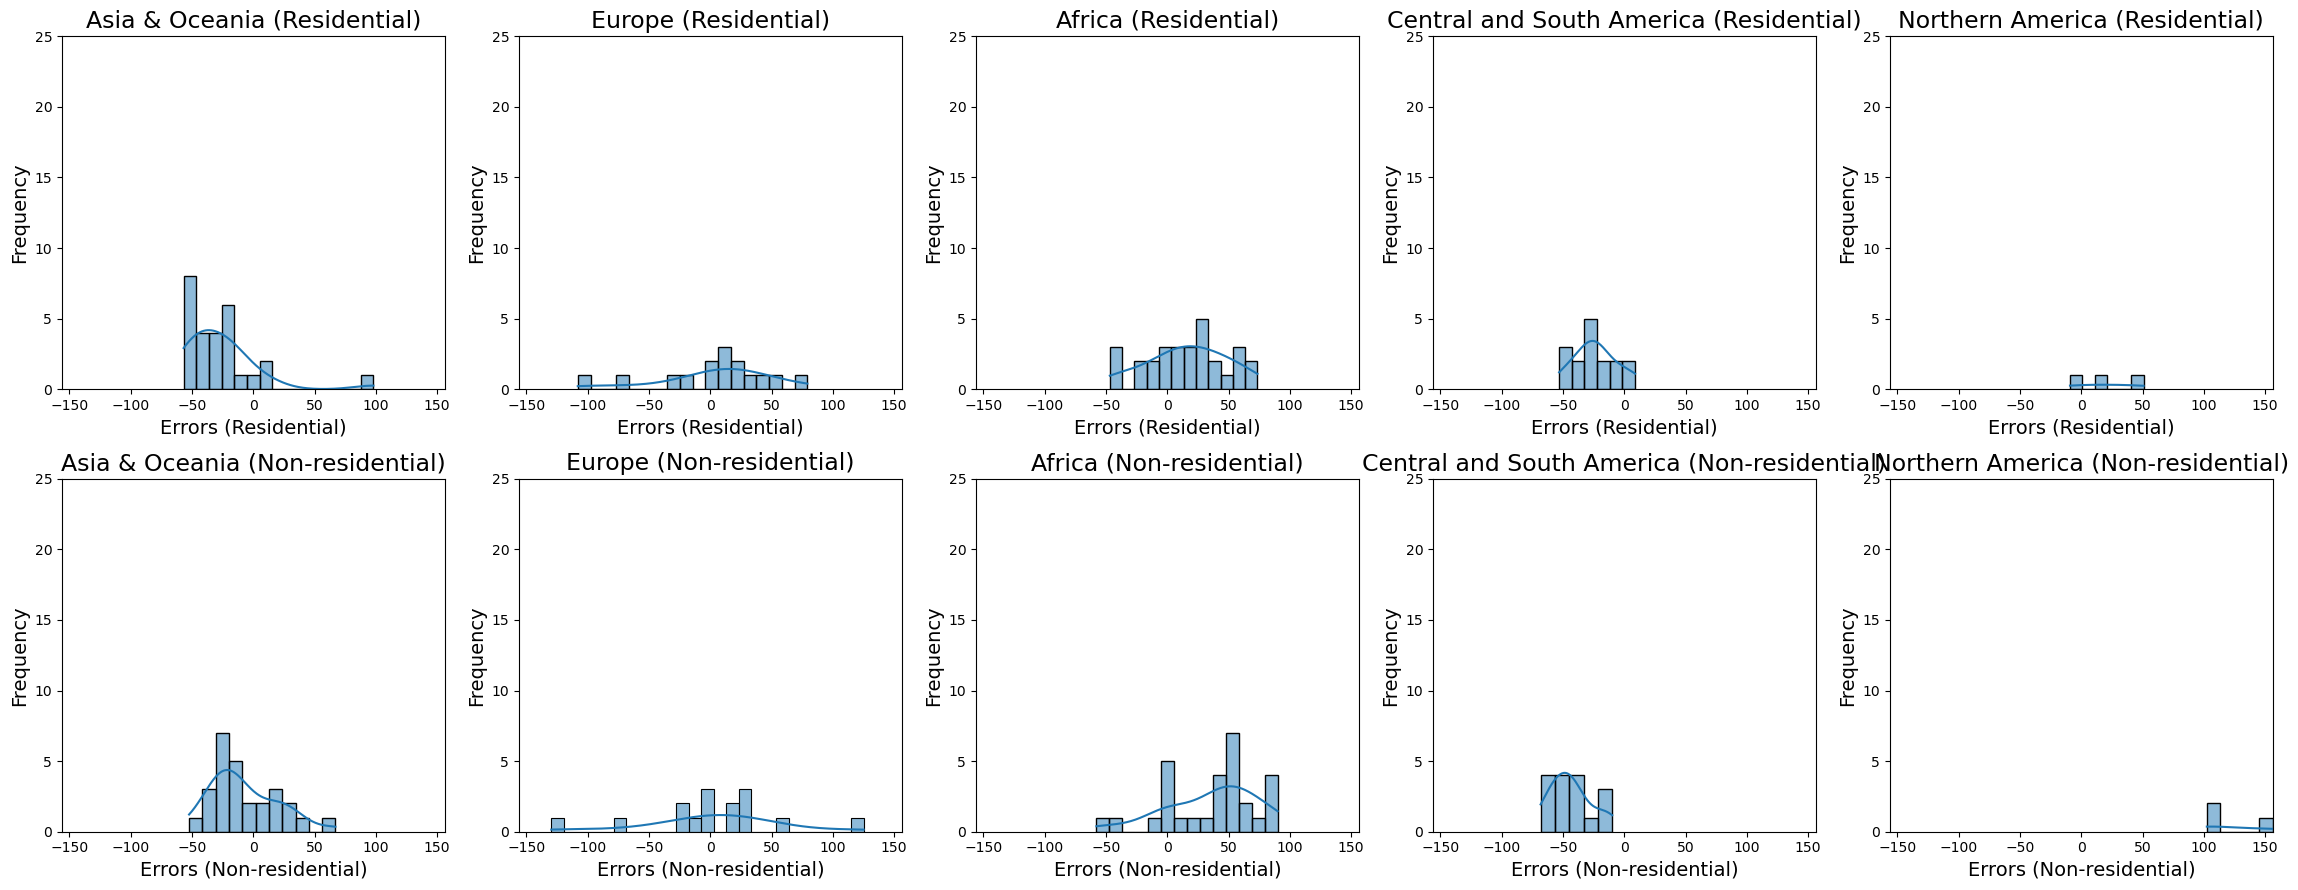

In [15]:
# Cross-domain with Ridge
model_ridge_cross = Ridge(**ridge_params)
results_ridge_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features, 
    model=model_ridge_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(
    results_ridge_cross,
    save_path=f'../figures/model_plots/{feature_selection}/ridge_cross_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_ridge_cross,
    save_path=f'../figures/model_plots/{feature_selection}/ridge_cross_domain_error_distribution.png'
)

### Linear Regression - Ridge - All Domain

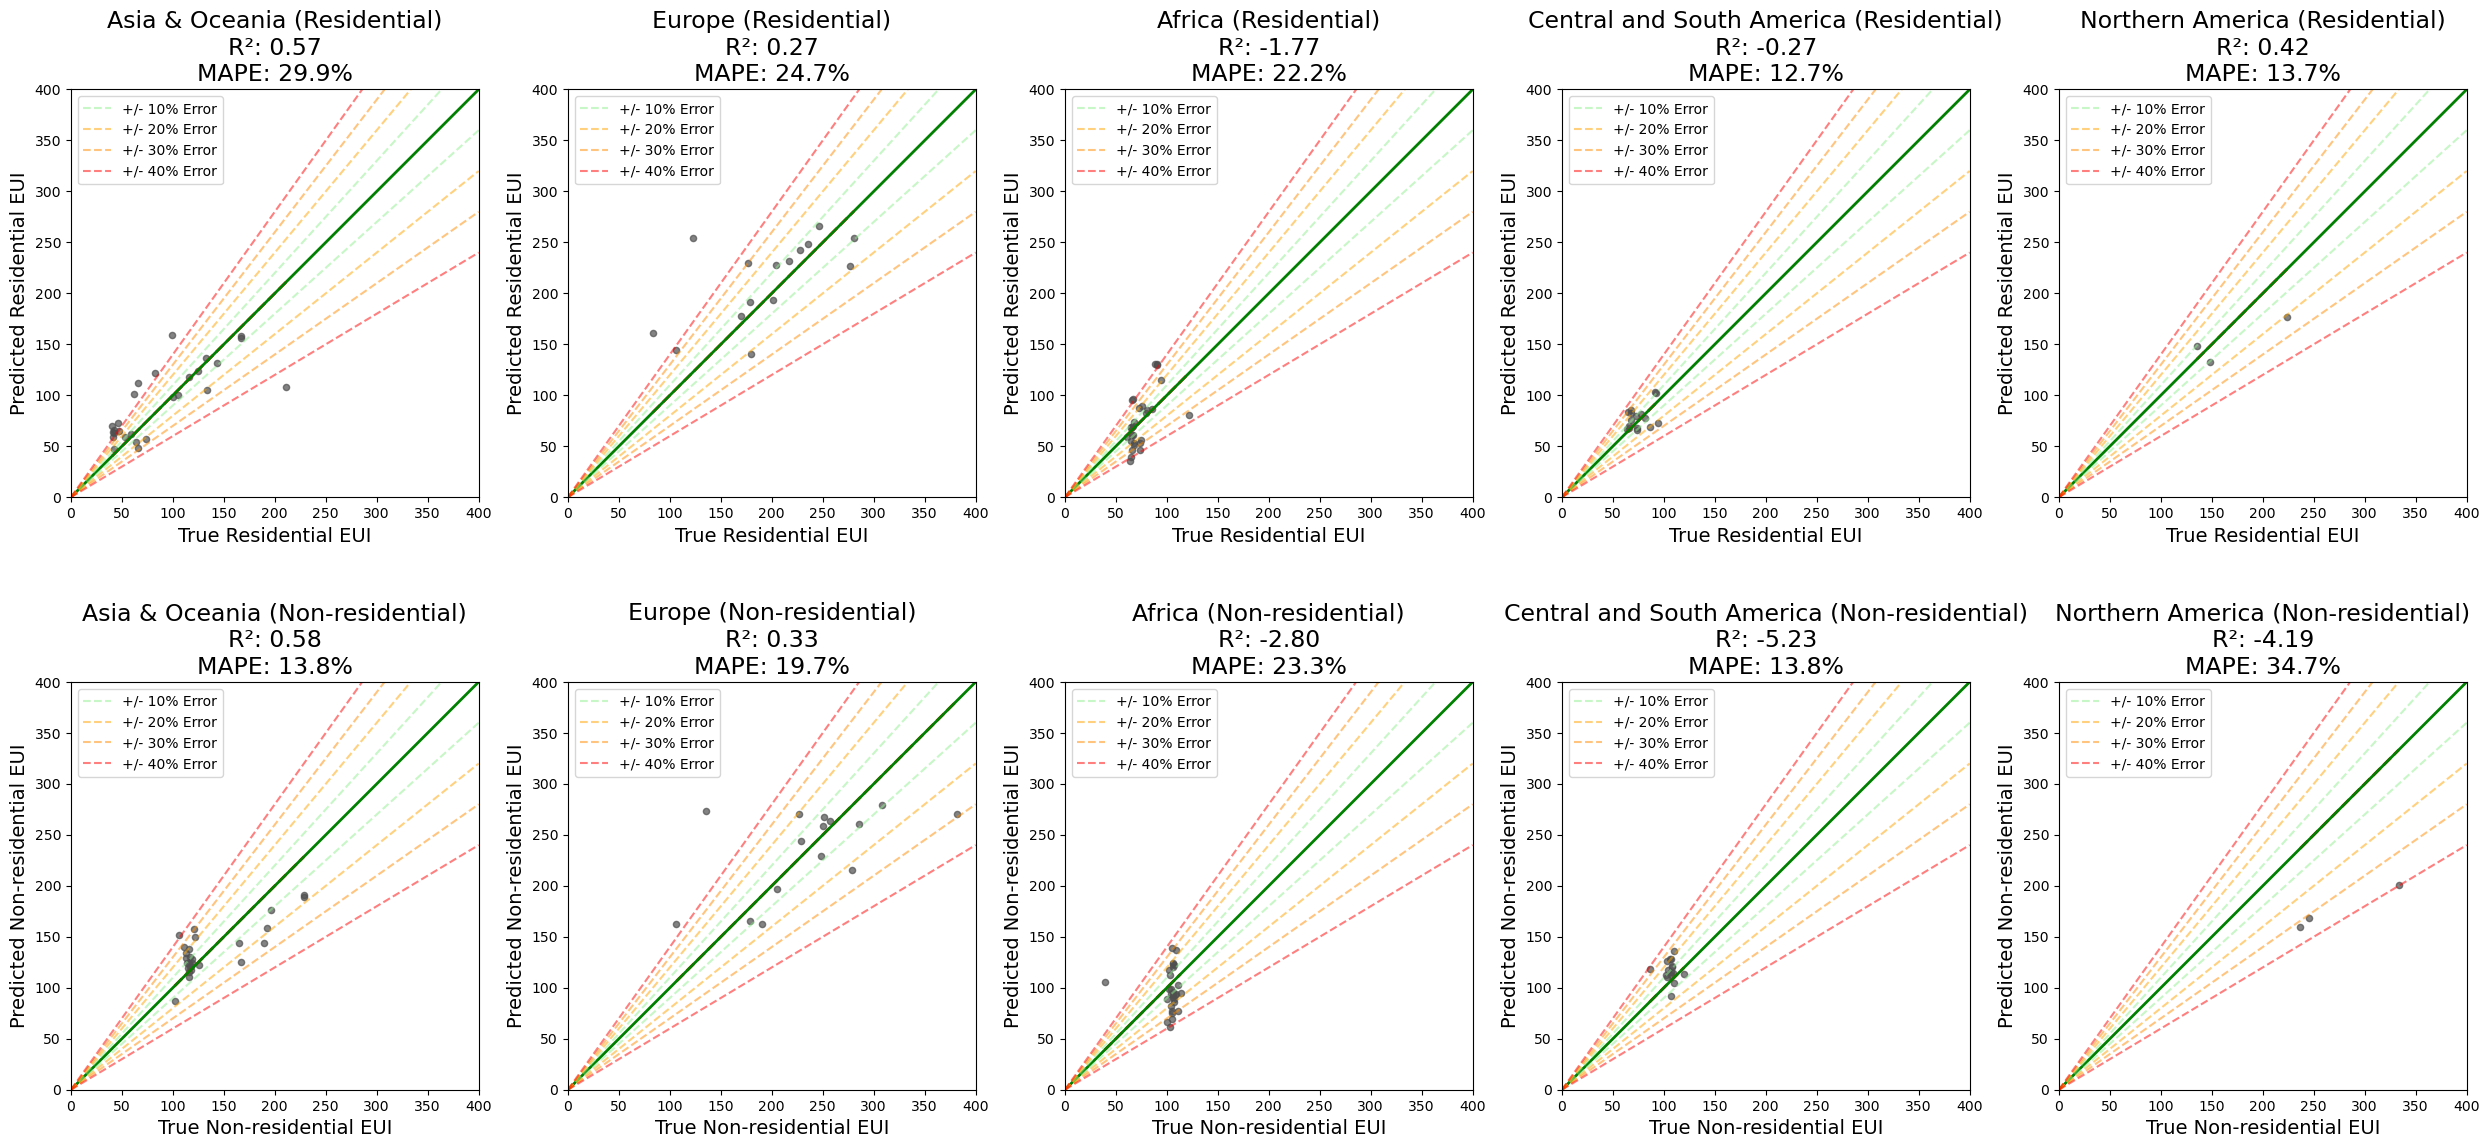

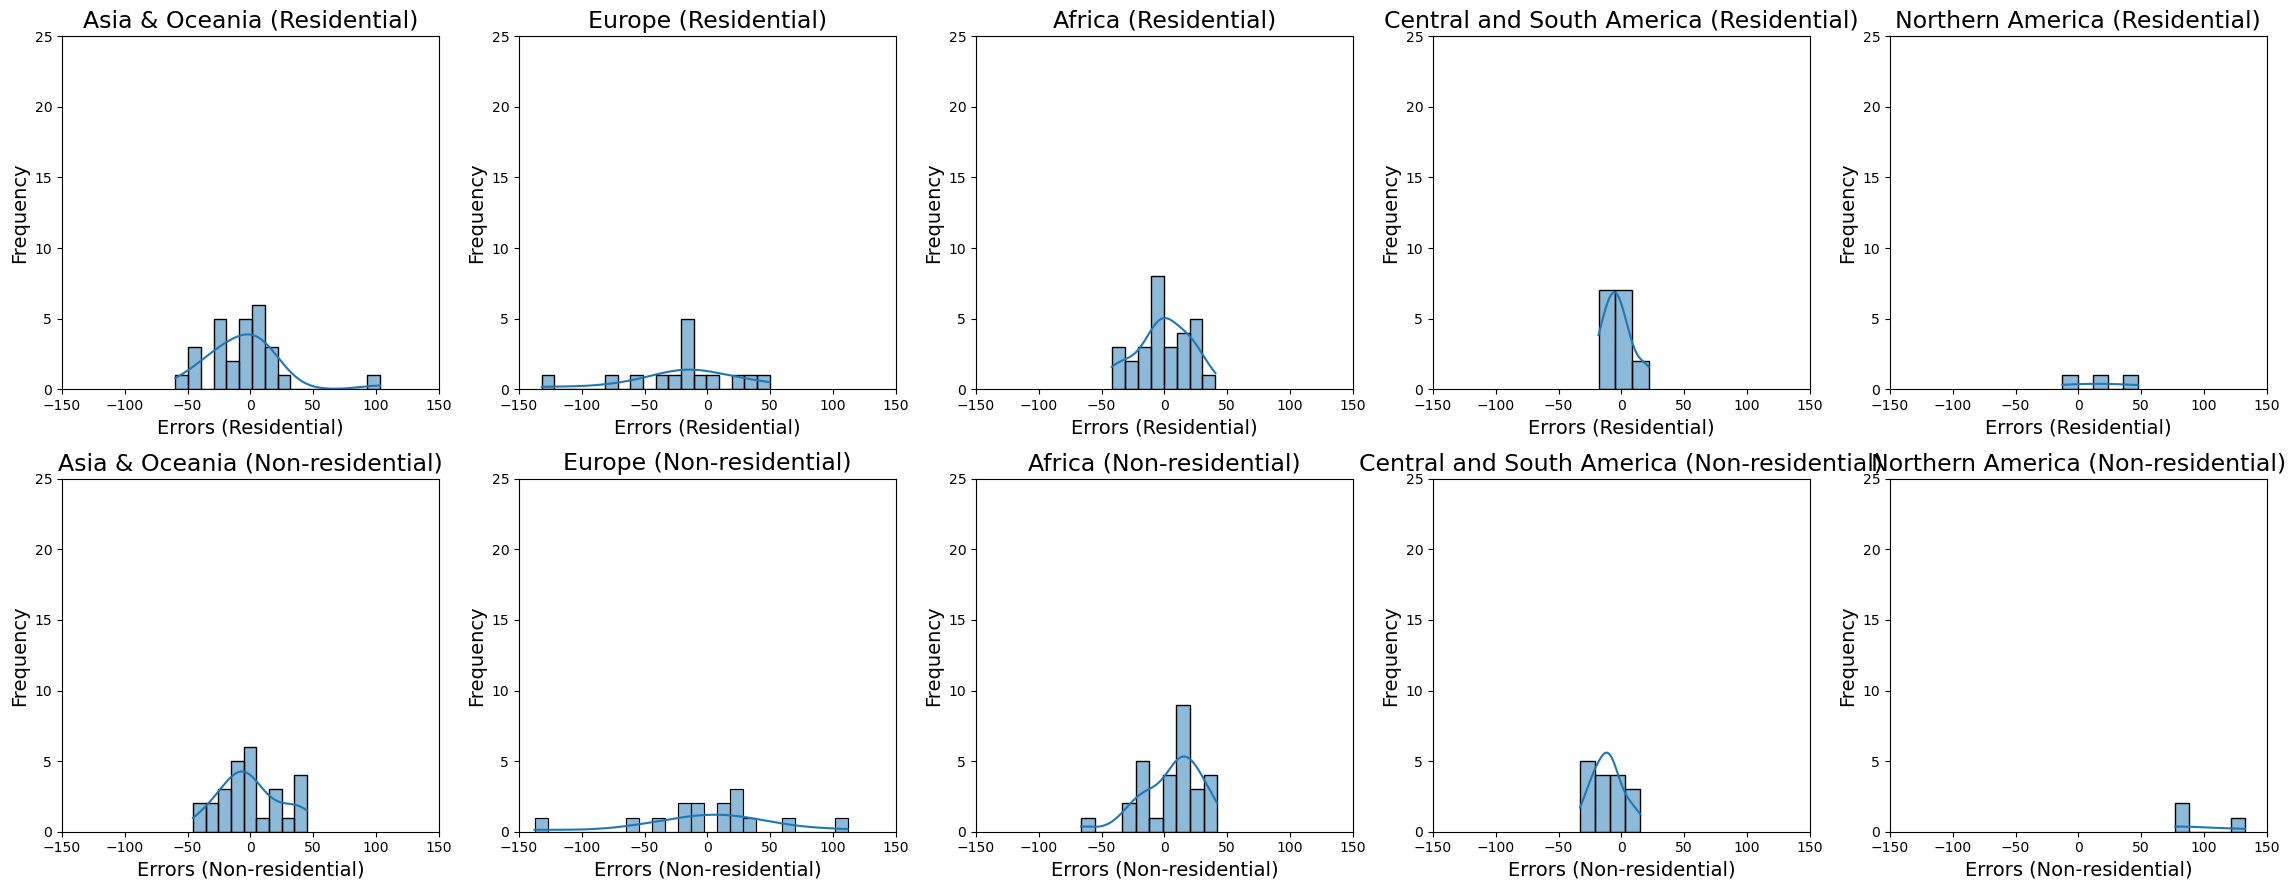

In [16]:
model_ridge_all = Ridge(**ridge_params)
results_ridge_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_ridge_all, 
    strategy='all_domain'
)

create_eui_comparison_plots(
    results_ridge_all,
    save_path=f'../figures/model_plots/{feature_selection}/ridge_all_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_ridge_all,
    save_path=f'../figures/model_plots/{feature_selection}/ridge_all_domain_error_distribution.png'
)


In [17]:
RidgeModel = lambda: Ridge(**ridge_params)

ridge_detailed_results = evaluate_model_strategies(
   merged_df=merged_df,
   regions=regions,
   features=features,
   model_type=RidgeModel,
   feature_abbreviations=feature_abbreviations,
   model_details="Ridge, " + ", ".join(f"{k}={v}" for k, v in ridge_params.items())
)
ridge_detailed_results['Model'] = 'LR Ridge'
ridge_average_results = calculate_average_metrics(ridge_detailed_results).reset_index()

ridge_average_results

Target       Strategy     Model  \
0  Non-residential EUI (kWh/m2/year)  within_domain  LR Ridge   
1  Non-residential EUI (kWh/m2/year)   cross_domain  LR Ridge   
2  Non-residential EUI (kWh/m2/year)     all_domain  LR Ridge   
3      Residential EUI (kWh/m2/year)  within_domain  LR Ridge   
4      Residential EUI (kWh/m2/year)   cross_domain  LR Ridge   
5      Residential EUI (kWh/m2/year)     all_domain  LR Ridge   

      Model Details                                      Features Used  \
0  Ridge, alpha=1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
1  Ridge, alpha=1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
2  Ridge, alpha=1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
3  Ridge, alpha=1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
4  Ridge, alpha=1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
5  Ridge, alpha=1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   

                                Features Abbreviated   MAPE      R²       MSE  \
0  Heating Degree Days | Cooling Degree Days | GD...  15.12  -0.203  2180.529   
1  Heating Degree Days | Cooling Degree Days | GD...  33.70 -14.214  4747.796   
2  Heating Degree Days | Cooling Degree Days | GD...  21.06  -2.264  2849.405   
3  Heating Degree Days | Cooling Degree Days | GD...  20.64   0.166  1622.819   
4  Heating Degree Days | Cooling Degree Days | GD...  33.70  -2.599  1371.470   
5  Heating Degree Days | Cooling Degree Days | GD...  20.64  -0.155   936.921   

     RMSE     MAE   WAPE  
0  36.857  26.955  13.18  
1  60.804  54.110  32.36  
2  43.685  37.766  19.88  
3  31.537  23.854  17.66  
4  36.562  30.204  29.44  
5  28.175  21.735  18.66

In [18]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

ridge_detailed_results.to_csv(f'../results/{feature_selection}/{timestamp}_ridge_detailed_results.csv')
ridge_average_results.to_csv(f'../results/{feature_selection}/{timestamp}_ridge_average_results.csv')


# Linear Regression - Lasso regularization

In [19]:
lasso_params = {
    'alpha': 1.0,          # regularization strength
  #  'fit_intercept': True, # include bias term
  #  'max_iter': 1000,      # maximum iterations
  #  'tol': 1e-4,          # tolerance for optimization
  #  'selection': 'cyclic', # feature selection method
  #  'random_state': 42     # for reproducibility
}

### Linear Regression - Lasso - Within Domain

/Users/barbaraflores/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.782e+00, tolerance: 9.922e-01
  model = cd_fast.enet_coordinate_descent(


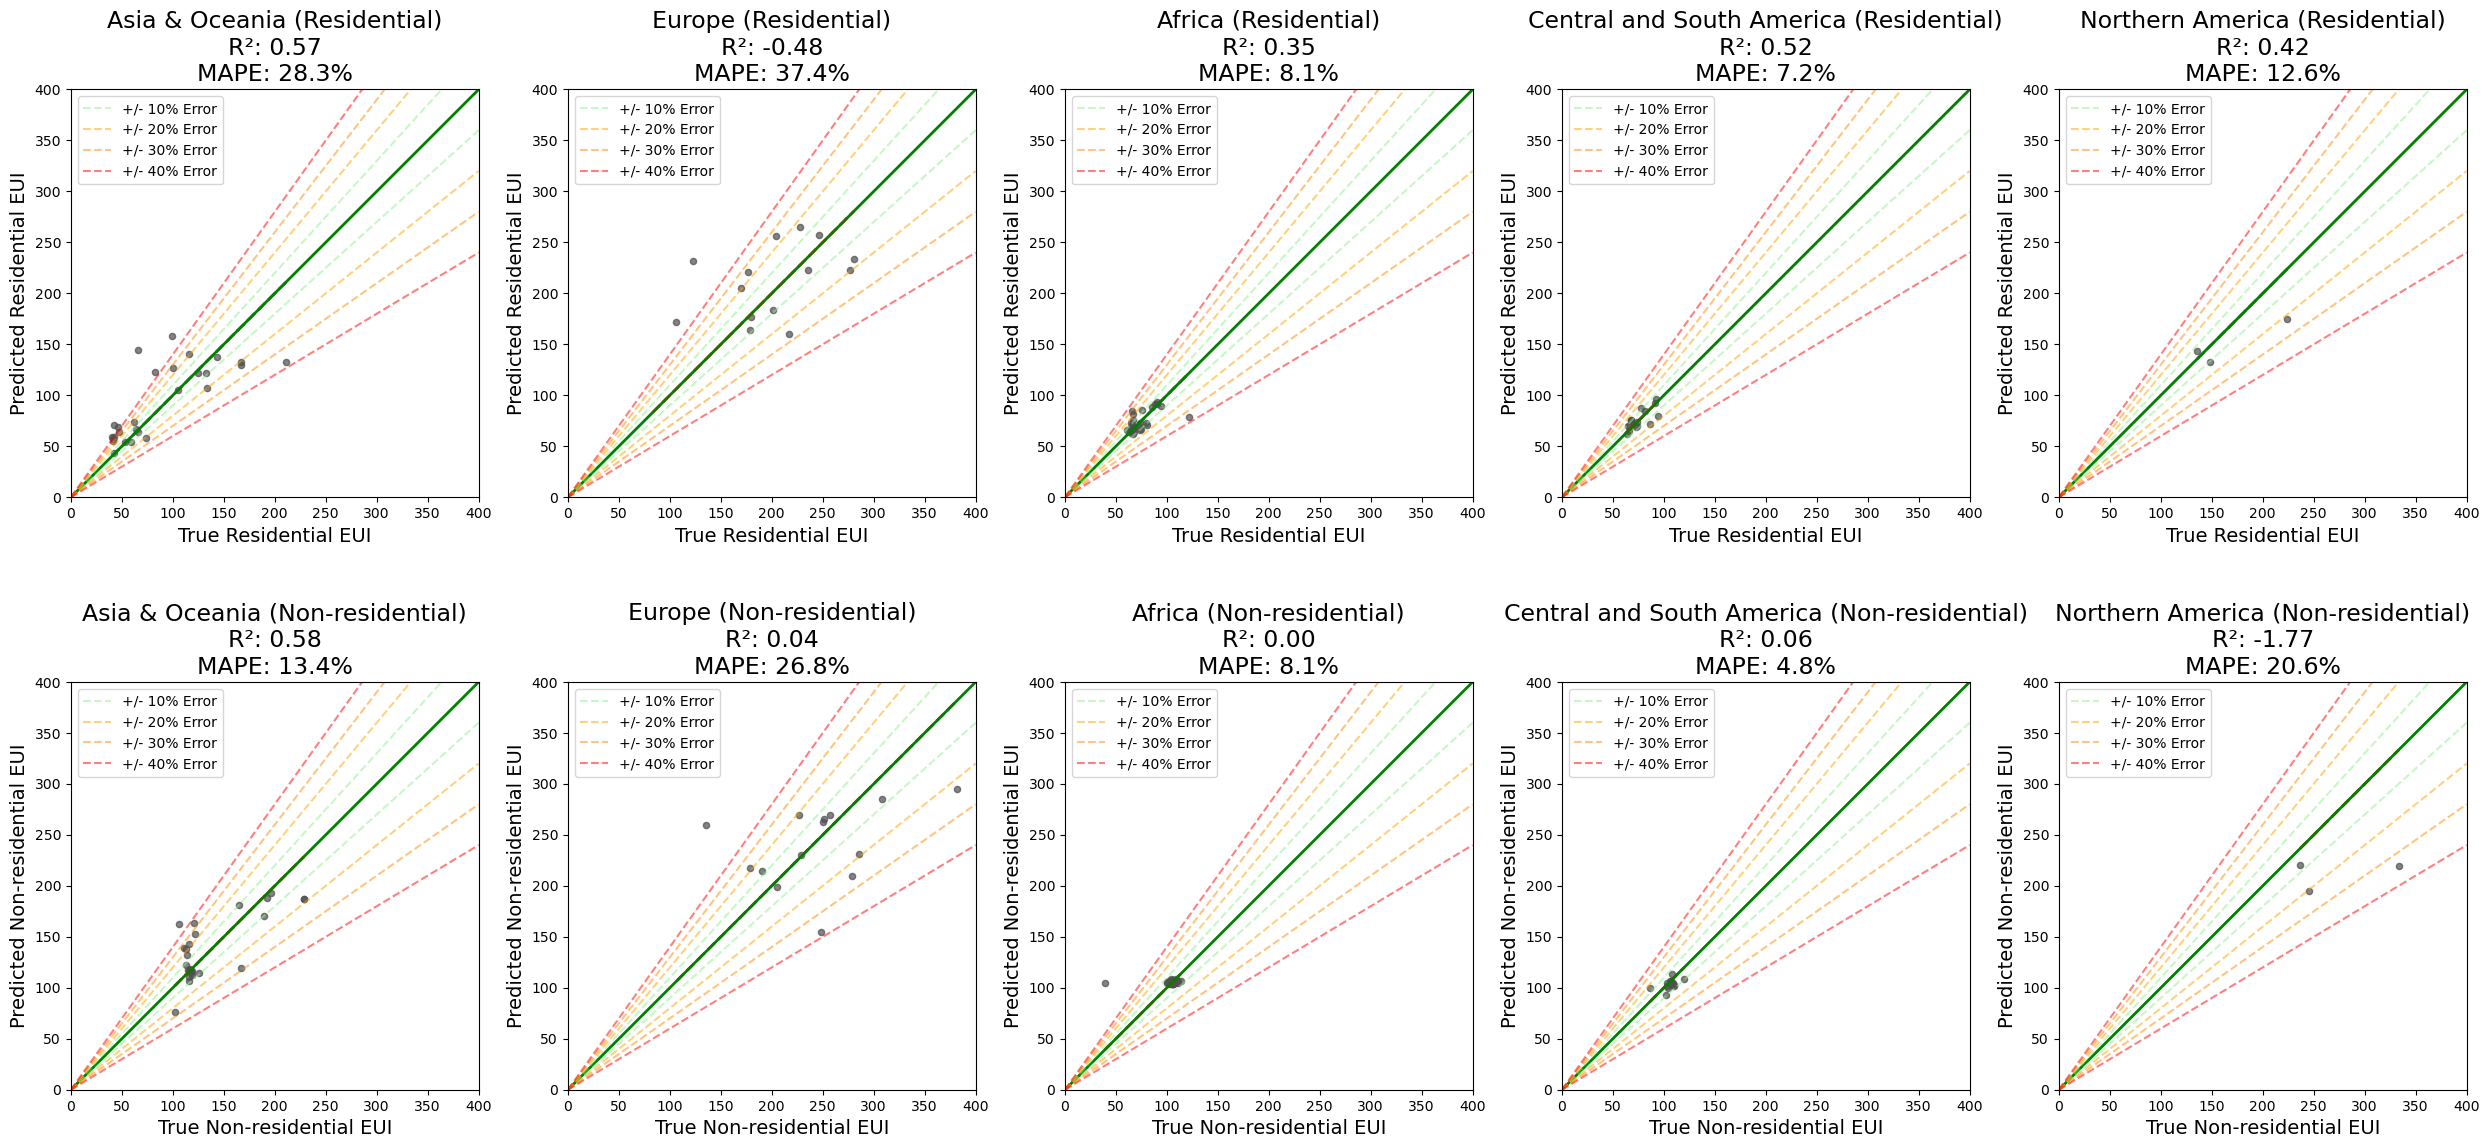

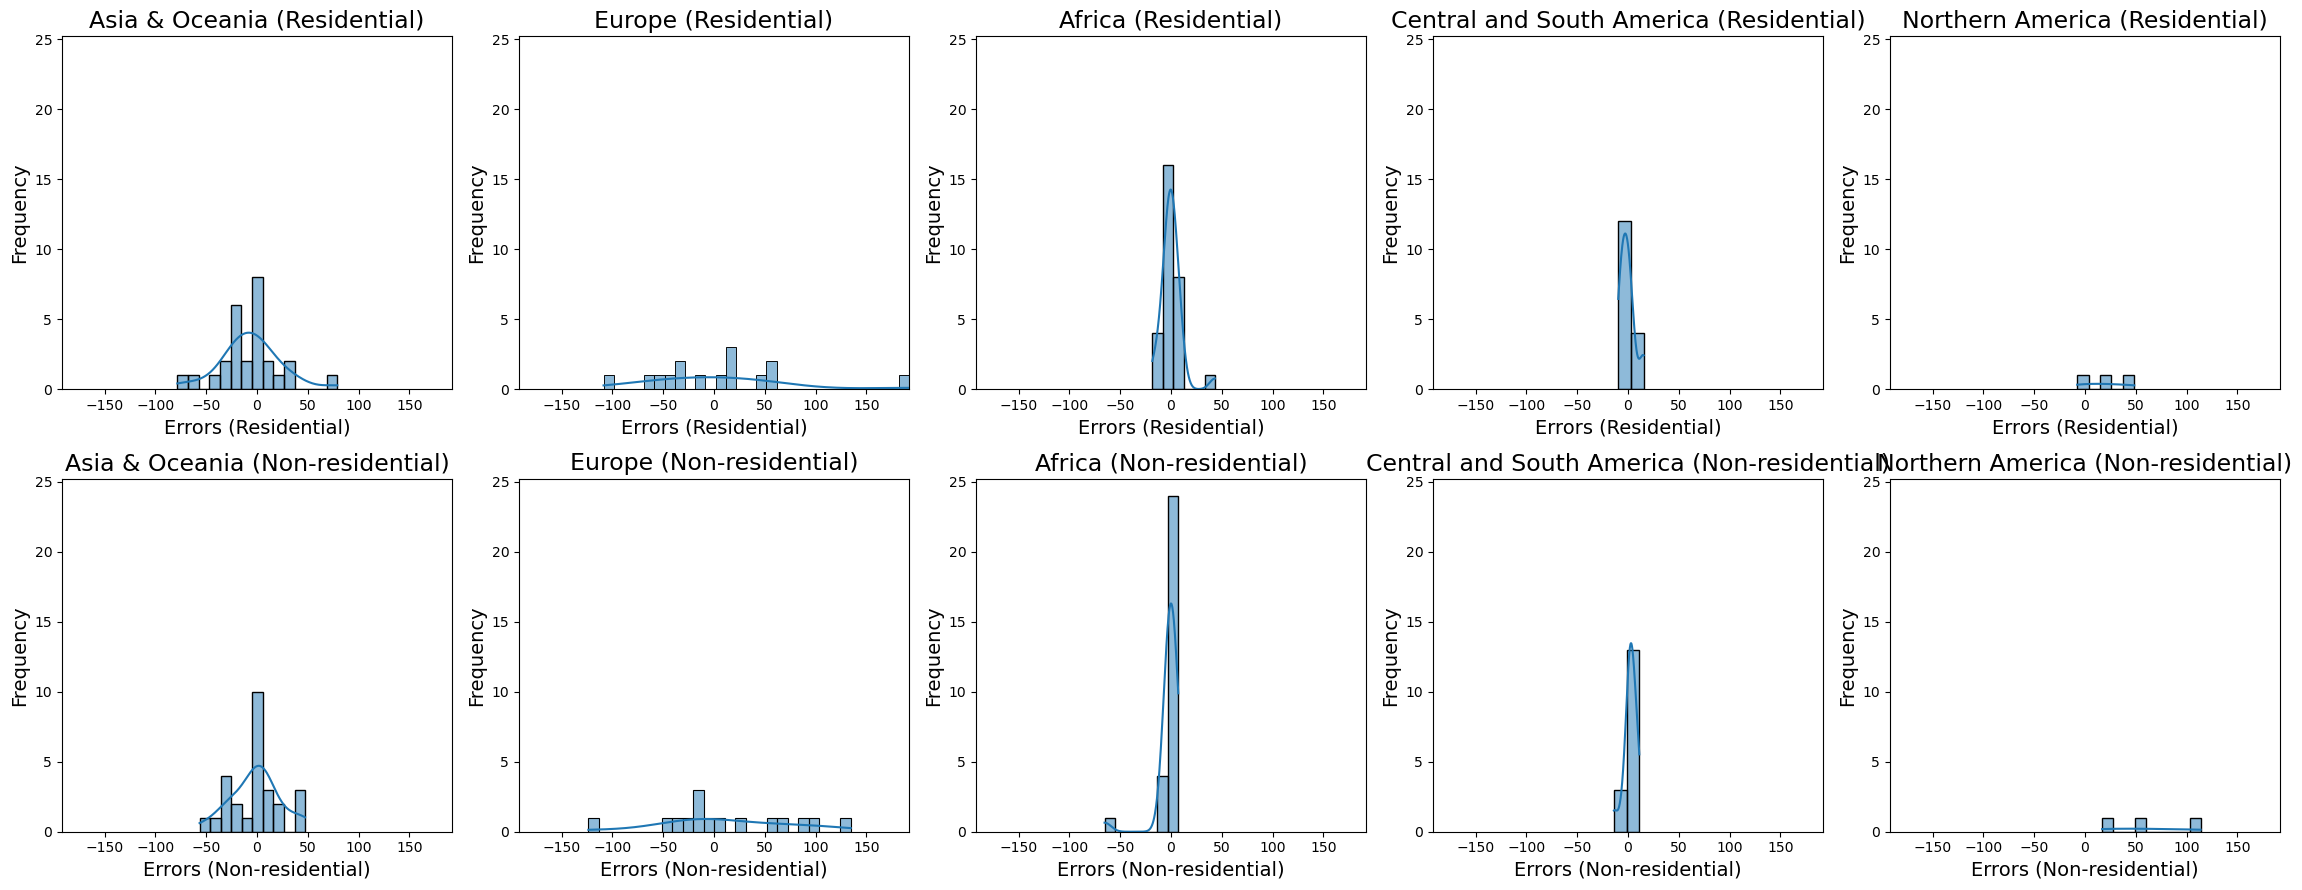

In [20]:
# Within-domain with Lasso
model_lasso_within = Lasso(**lasso_params)
results_lasso_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions, 
    features=features,
    model=model_lasso_within,
    strategy='within_domain'
)

create_eui_comparison_plots(
    results_lasso_within, 
    save_path=f'../figures/model_plots/{feature_selection}/lasso_within_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_lasso_within,
    save_path=f'../figures/model_plots/{feature_selection}/lasso_within_domain_error_distribution.png'
)


### Linear Regression - Lasso - Cross Domain

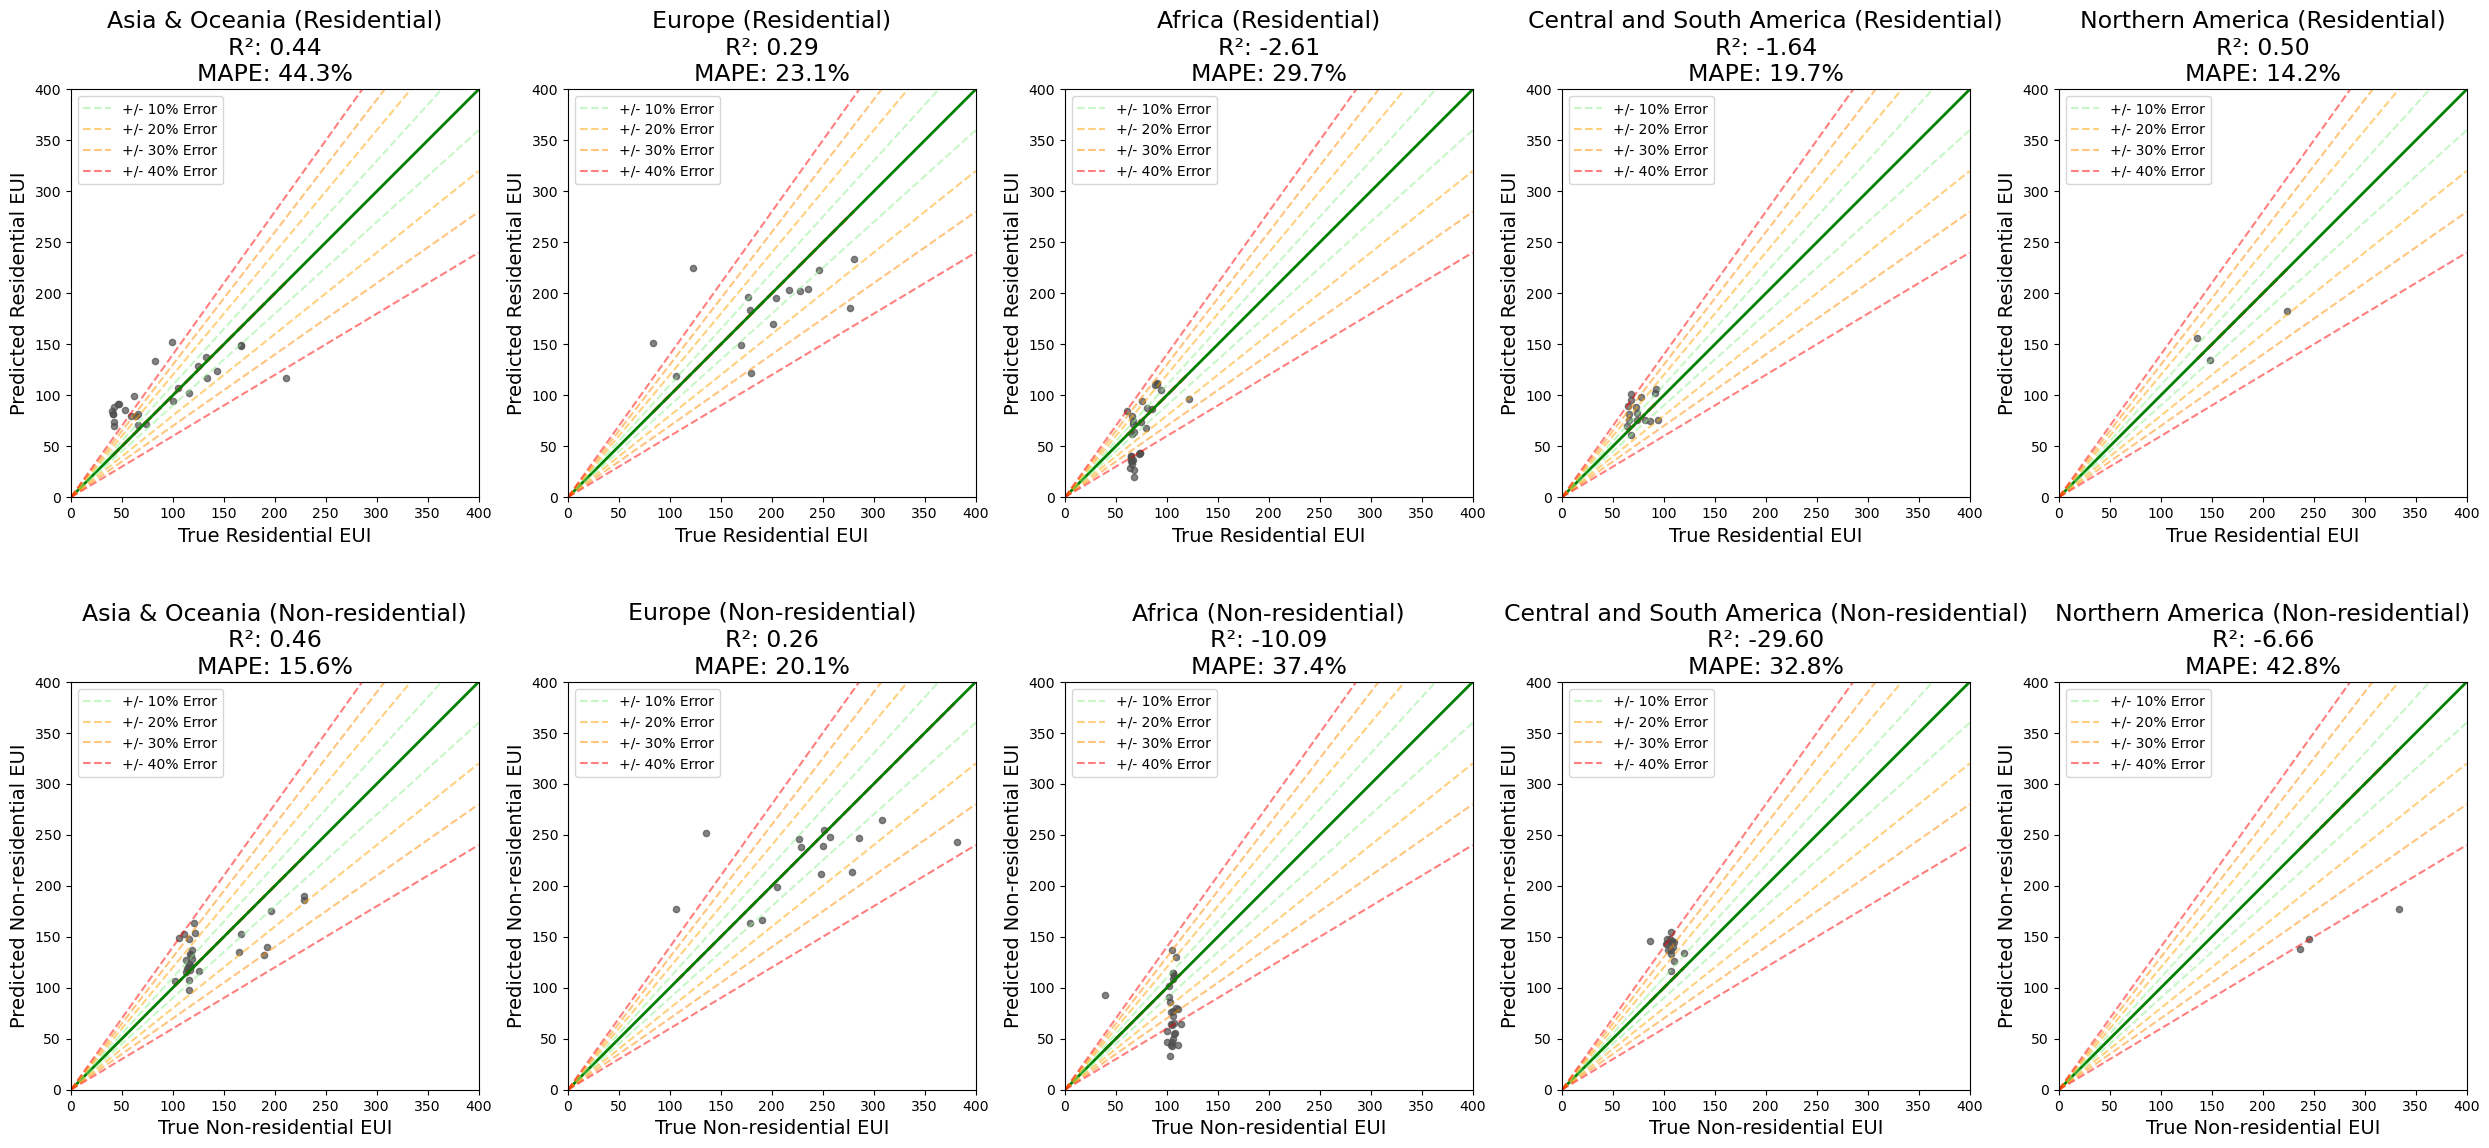

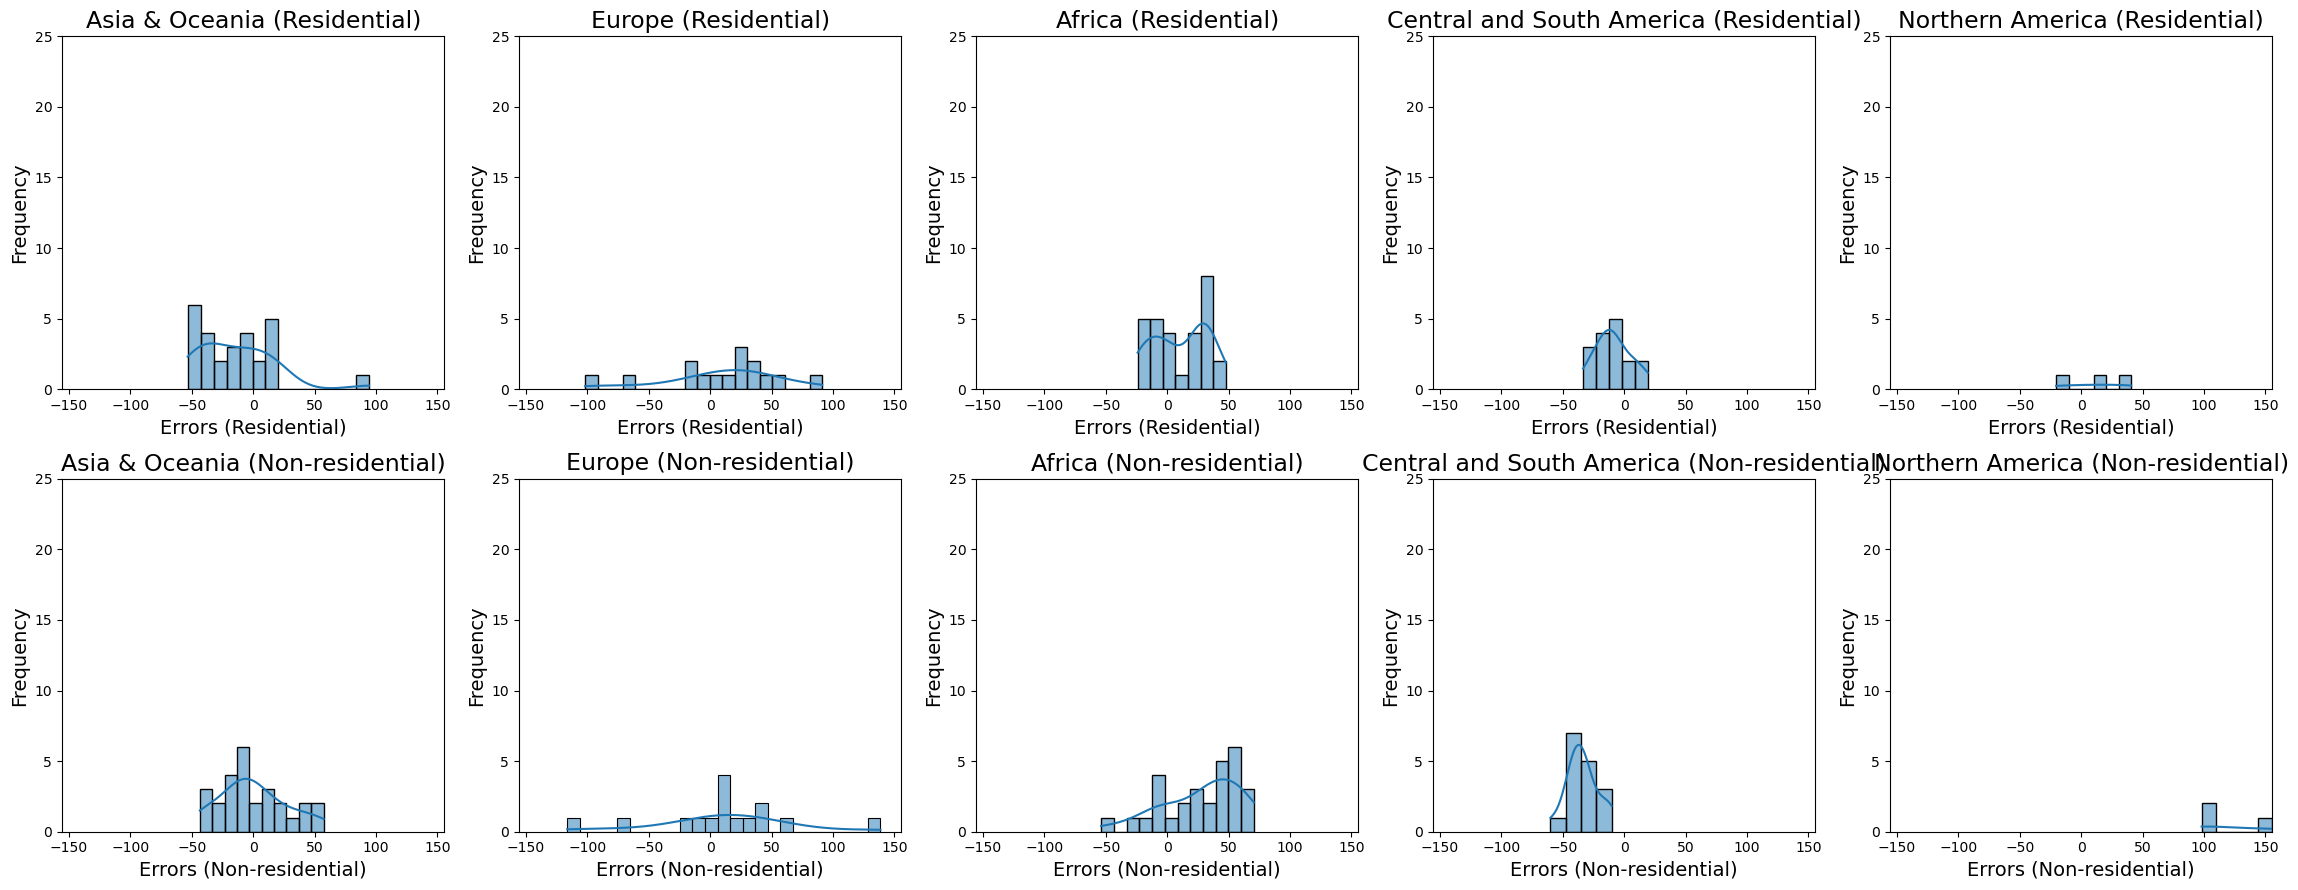

In [21]:
# Cross-domain with Lasso
model_lasso_cross = Lasso(**lasso_params)
results_lasso_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features, 
    model=model_lasso_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(
    results_lasso_cross,
    save_path=f'../figures/model_plots/{feature_selection}/lasso_cross_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_lasso_cross,
    save_path=f'../figures/model_plots/{feature_selection}/lasso_cross_domain_error_distribution.png'
)


### Linear Regression - Lasso - All Domain

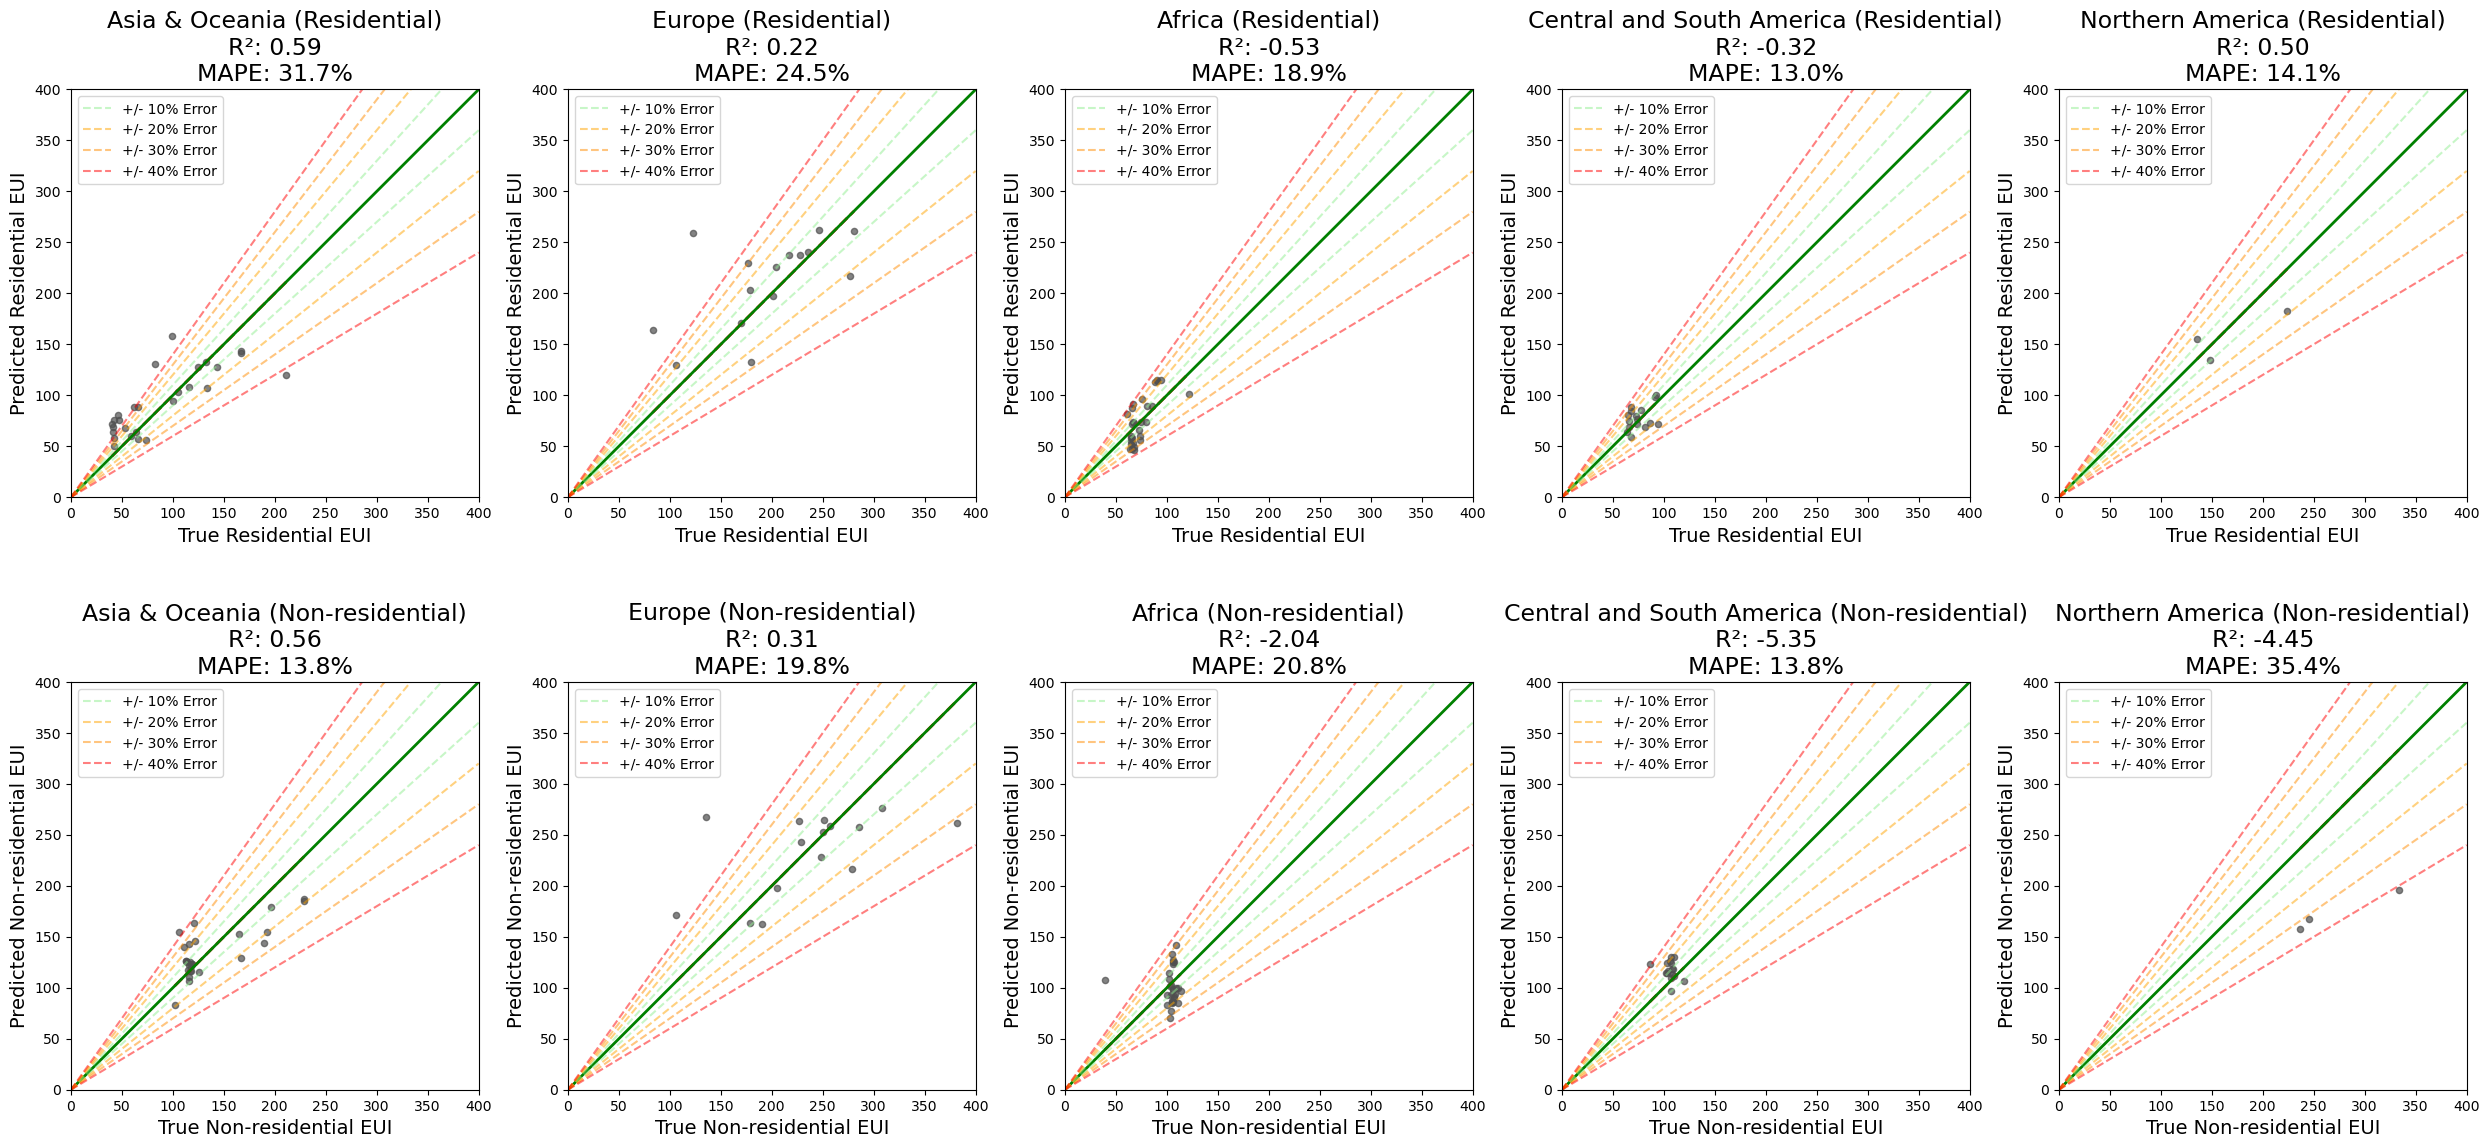

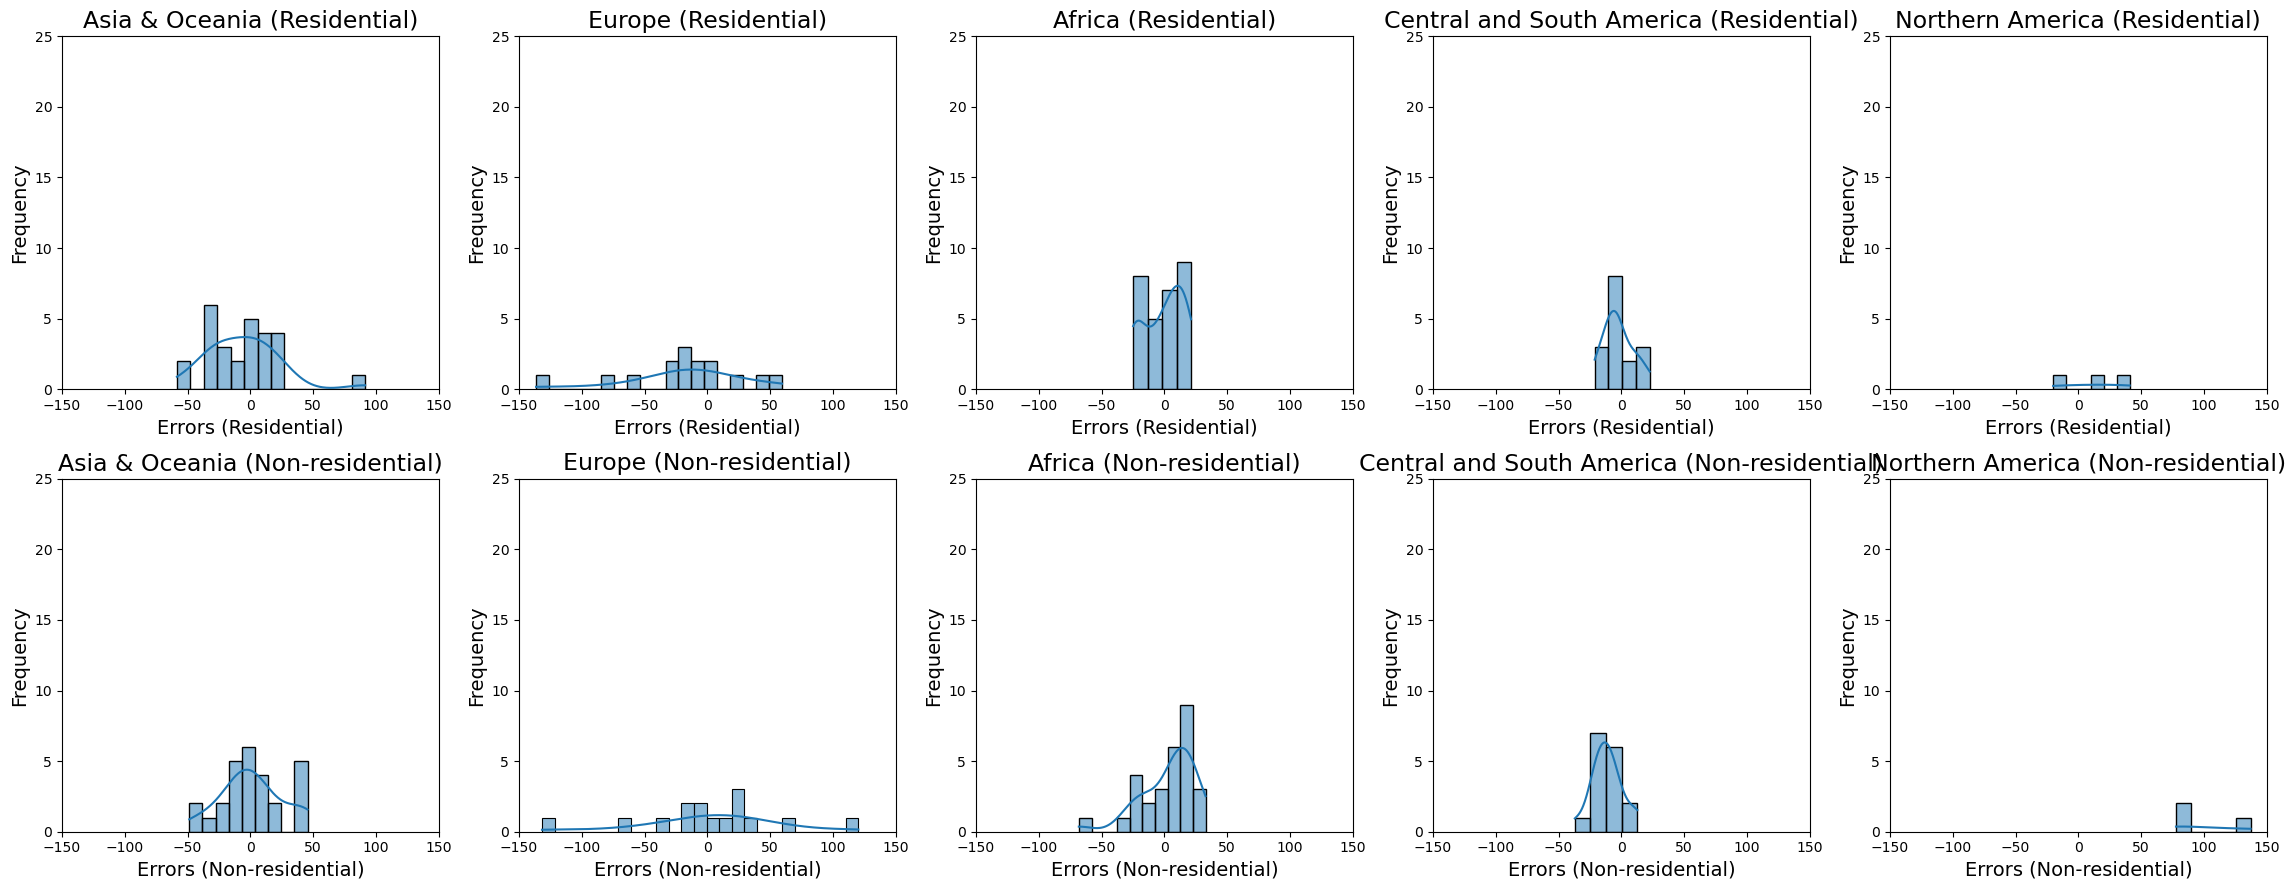

In [22]:
# All-domain with Lasso
model_lasso_all = Lasso(**lasso_params)
results_lasso_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_lasso_all, 
    strategy='all_domain'
)

create_eui_comparison_plots(
    results_lasso_all,
    save_path=f'../figures/model_plots/{feature_selection}/lasso_all_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_lasso_all,
    save_path=f'../figures/model_plots/{feature_selection}/lasso_all_domain_error_distribution.png'
)

In [23]:
LassoModel = lambda: Lasso(**lasso_params)

lasso_detailed_results = evaluate_model_strategies(
   merged_df=merged_df,
   regions=regions,
   features=features,
   model_type=LassoModel,  
   feature_abbreviations=feature_abbreviations,
   model_details="Lasso, " + ", ".join(f"{k} = {v}" for k, v in lasso_params.items())
)

lasso_detailed_results['Model'] = 'LR Lasso'
lasso_average_results = calculate_average_metrics(lasso_detailed_results).reset_index()
lasso_average_results

/Users/barbaraflores/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.782e+00, tolerance: 9.922e-01
  model = cd_fast.enet_coordinate_descent(


Target       Strategy     Model  \
0  Non-residential EUI (kWh/m2/year)  within_domain  LR Lasso   
1  Non-residential EUI (kWh/m2/year)   cross_domain  LR Lasso   
2  Non-residential EUI (kWh/m2/year)     all_domain  LR Lasso   
3      Residential EUI (kWh/m2/year)  within_domain  LR Lasso   
4      Residential EUI (kWh/m2/year)   cross_domain  LR Lasso   
5      Residential EUI (kWh/m2/year)     all_domain  LR Lasso   

        Model Details                                      Features Used  \
0  Lasso, alpha = 1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
1  Lasso, alpha = 1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
2  Lasso, alpha = 1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
3  Lasso, alpha = 1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
4  Lasso, alpha = 1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   
5  Lasso, alpha = 1.0  hdd_total_year, cdd_total_year, GDP_per_capita...   

                                Features Abbreviated   MAPE     R²       MSE  \
0  Heating Degree Days | Cooling Degree Days | GD...  14.74 -0.218  2043.626   
1  Heating Degree Days | Cooling Degree Days | GD...  29.74 -9.128  4322.546   
2  Heating Degree Days | Cooling Degree Days | GD...  20.72 -2.194  2944.061   
3  Heating Degree Days | Cooling Degree Days | GD...  18.72  0.275  1323.662   
4  Heating Degree Days | Cooling Degree Days | GD...  26.20 -0.602  1012.011   
5  Heating Degree Days | Cooling Degree Days | GD...  20.44  0.092   896.985   

     RMSE     MAE   WAPE  
0  36.049  27.456  13.10  
1  56.603  50.113  28.76  
2  43.932  37.610  19.48  
3  29.193  21.630  16.26  
4  30.091  25.146  22.66  
5  26.891  21.225  18.00

In [24]:
lasso_detailed_results.to_csv(f'../results/{feature_selection}/{timestamp}_lasso_detailed_results.csv')
lasso_average_results.to_csv(f'../results/{feature_selection}/{timestamp}_lasso_average_results.csv')
